In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

First, remove artefacts, center and smoothen the raw GROMACS trajectories using the `trjconv` module.

```bash
gmx trjconv -s md500.tpr -f md500.xtc -n index.ndx -o md500_compact.xtc -center -pbc mol -ur compact
gmx trjconv -s md500.tpr -f md500_compact.xtc -n index.ndx -o md500_compact_compact.xtc -fit rot+trans
```

Dump out the first frame of the trajectory

```bash
gmx trjconv -s md500.tpr -f md500_compact.xtc -n index.ndx -o md500_start.pdb -dump 0
```

In all cases, Choose `Protein` for centering and `Protein_LIG_ZN2` for output. Not selecting the whole system for output removes water and loose ions and compresses the trajectory files.



## RMSD Calculation

In [2]:
#Read all the trajectories
mmp9_01 = mda.Universe('1l6j_only/compact_xtc/start_1.pdb','1l6j_only/compact_xtc/md500_1_fit.xtc')

mmp9_02 = mda.Universe('1l6j_only/compact_xtc/start_2.pdb', '1l6j_only/compact_xtc/md500_2_fit.xtc')

mmp9_03 = mda.Universe('1l6j_only/compact_xtc/start_3.pdb','1l6j_only/compact_xtc/md500_3_fit.xtc')

mmp9_04 = mda.Universe('1l6j_only/compact_xtc/start_4.pdb', '1l6j_only/compact_xtc/md500_4_fit.xtc')

mmp9_sb3ct_01 = mda.Universe('1l6j_run1/md500_start.pdb', '1l6j_run1/md500_compact_compact.xtc')
mmp9_sb3ct_02 = mda.Universe('1l6j_run2/md500_start.pdb', '1l6j_run2/md500_compact_compact.xtc')

## RMSD: Individual Plots

In [3]:
from MDAnalysis.analysis import rms

rmsd_dict_freemmp9 = {}

for i,u in enumerate([mmp9_01, mmp9_02, mmp9_03, mmp9_04]):
    R = rms.RMSD(u,  # universe to align
        u,  # reference universe or atomgroup
        select='backbone',  # group to superimpose and calculate RMSD
        ref_frame=0)  # frame index of the reference

    R.run(verbose=True)
    times = R.results.rmsd[:,1]
    rmsd = R.results.rmsd[:,2]
    rmsd_dict_freemmp9[str(i)] = np.vstack((times, rmsd)).T

rmsd_dict_mmp9sb3ct = {}

for i, u in enumerate([mmp9_sb3ct_01, mmp9_sb3ct_02]):
    R = rms.RMSD(u,  # universe to align
        u,  # reference universe or atomgroup
        select='backbone',  # group to superimpose and calculate RMSD
        ref_frame=0)  # frame index of the reference

    R.run(verbose=True)
    times = R.results.rmsd[:,1]
    rmsd = R.results.rmsd[:,2]
    rmsd_dict_mmp9sb3ct[str(i)] = np.vstack((times, rmsd)).T

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

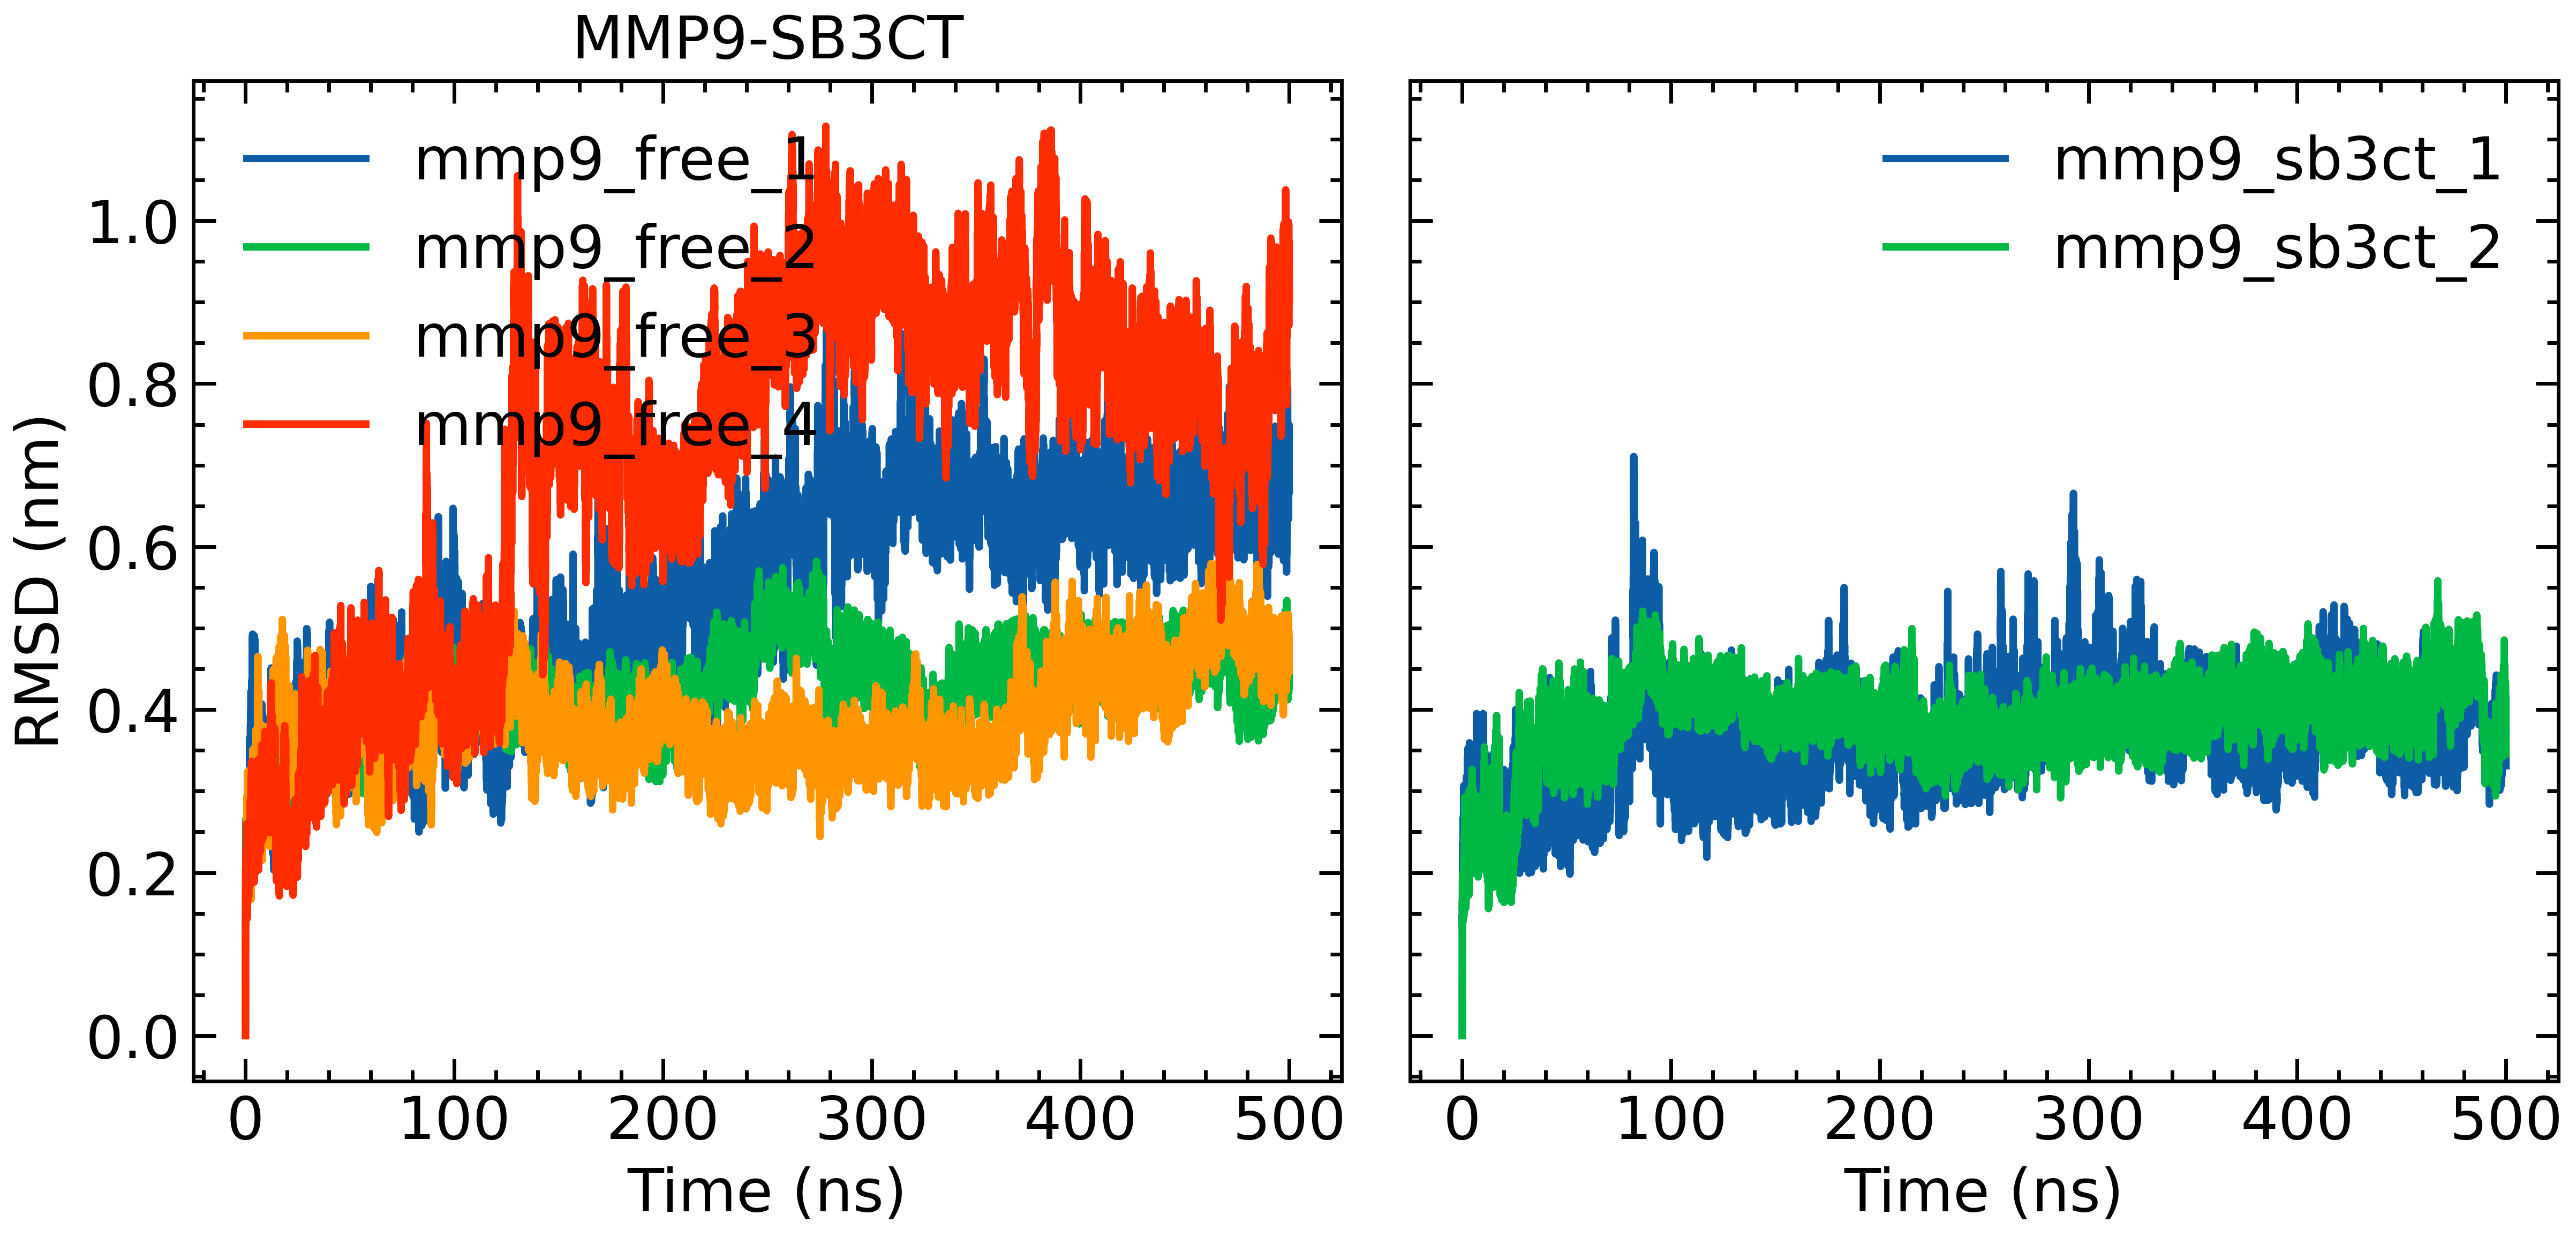

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
for i in range(4):
    ax[0].plot(rmsd_dict_freemmp9[str(i)][:,0]/1000, rmsd_dict_freemmp9[str(i)][:,1]/10, label='mmp9_free_'+str(i+1))
for i in range(2):
    ax[1].plot(rmsd_dict_mmp9sb3ct[str(i)][:,0]/1000, rmsd_dict_mmp9sb3ct[str(i)][:,1]/10, label='mmp9_sb3ct_'+str(i+1))

ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('RMSD (nm)')
ax[0].legend()
ax[1].legend()
ax[0].set_title('MMP9 Free')
ax[0].set_title('MMP9-SB3CT')
ax[1].set_xlabel('Time (ns)');


## RMSD: Average Plots

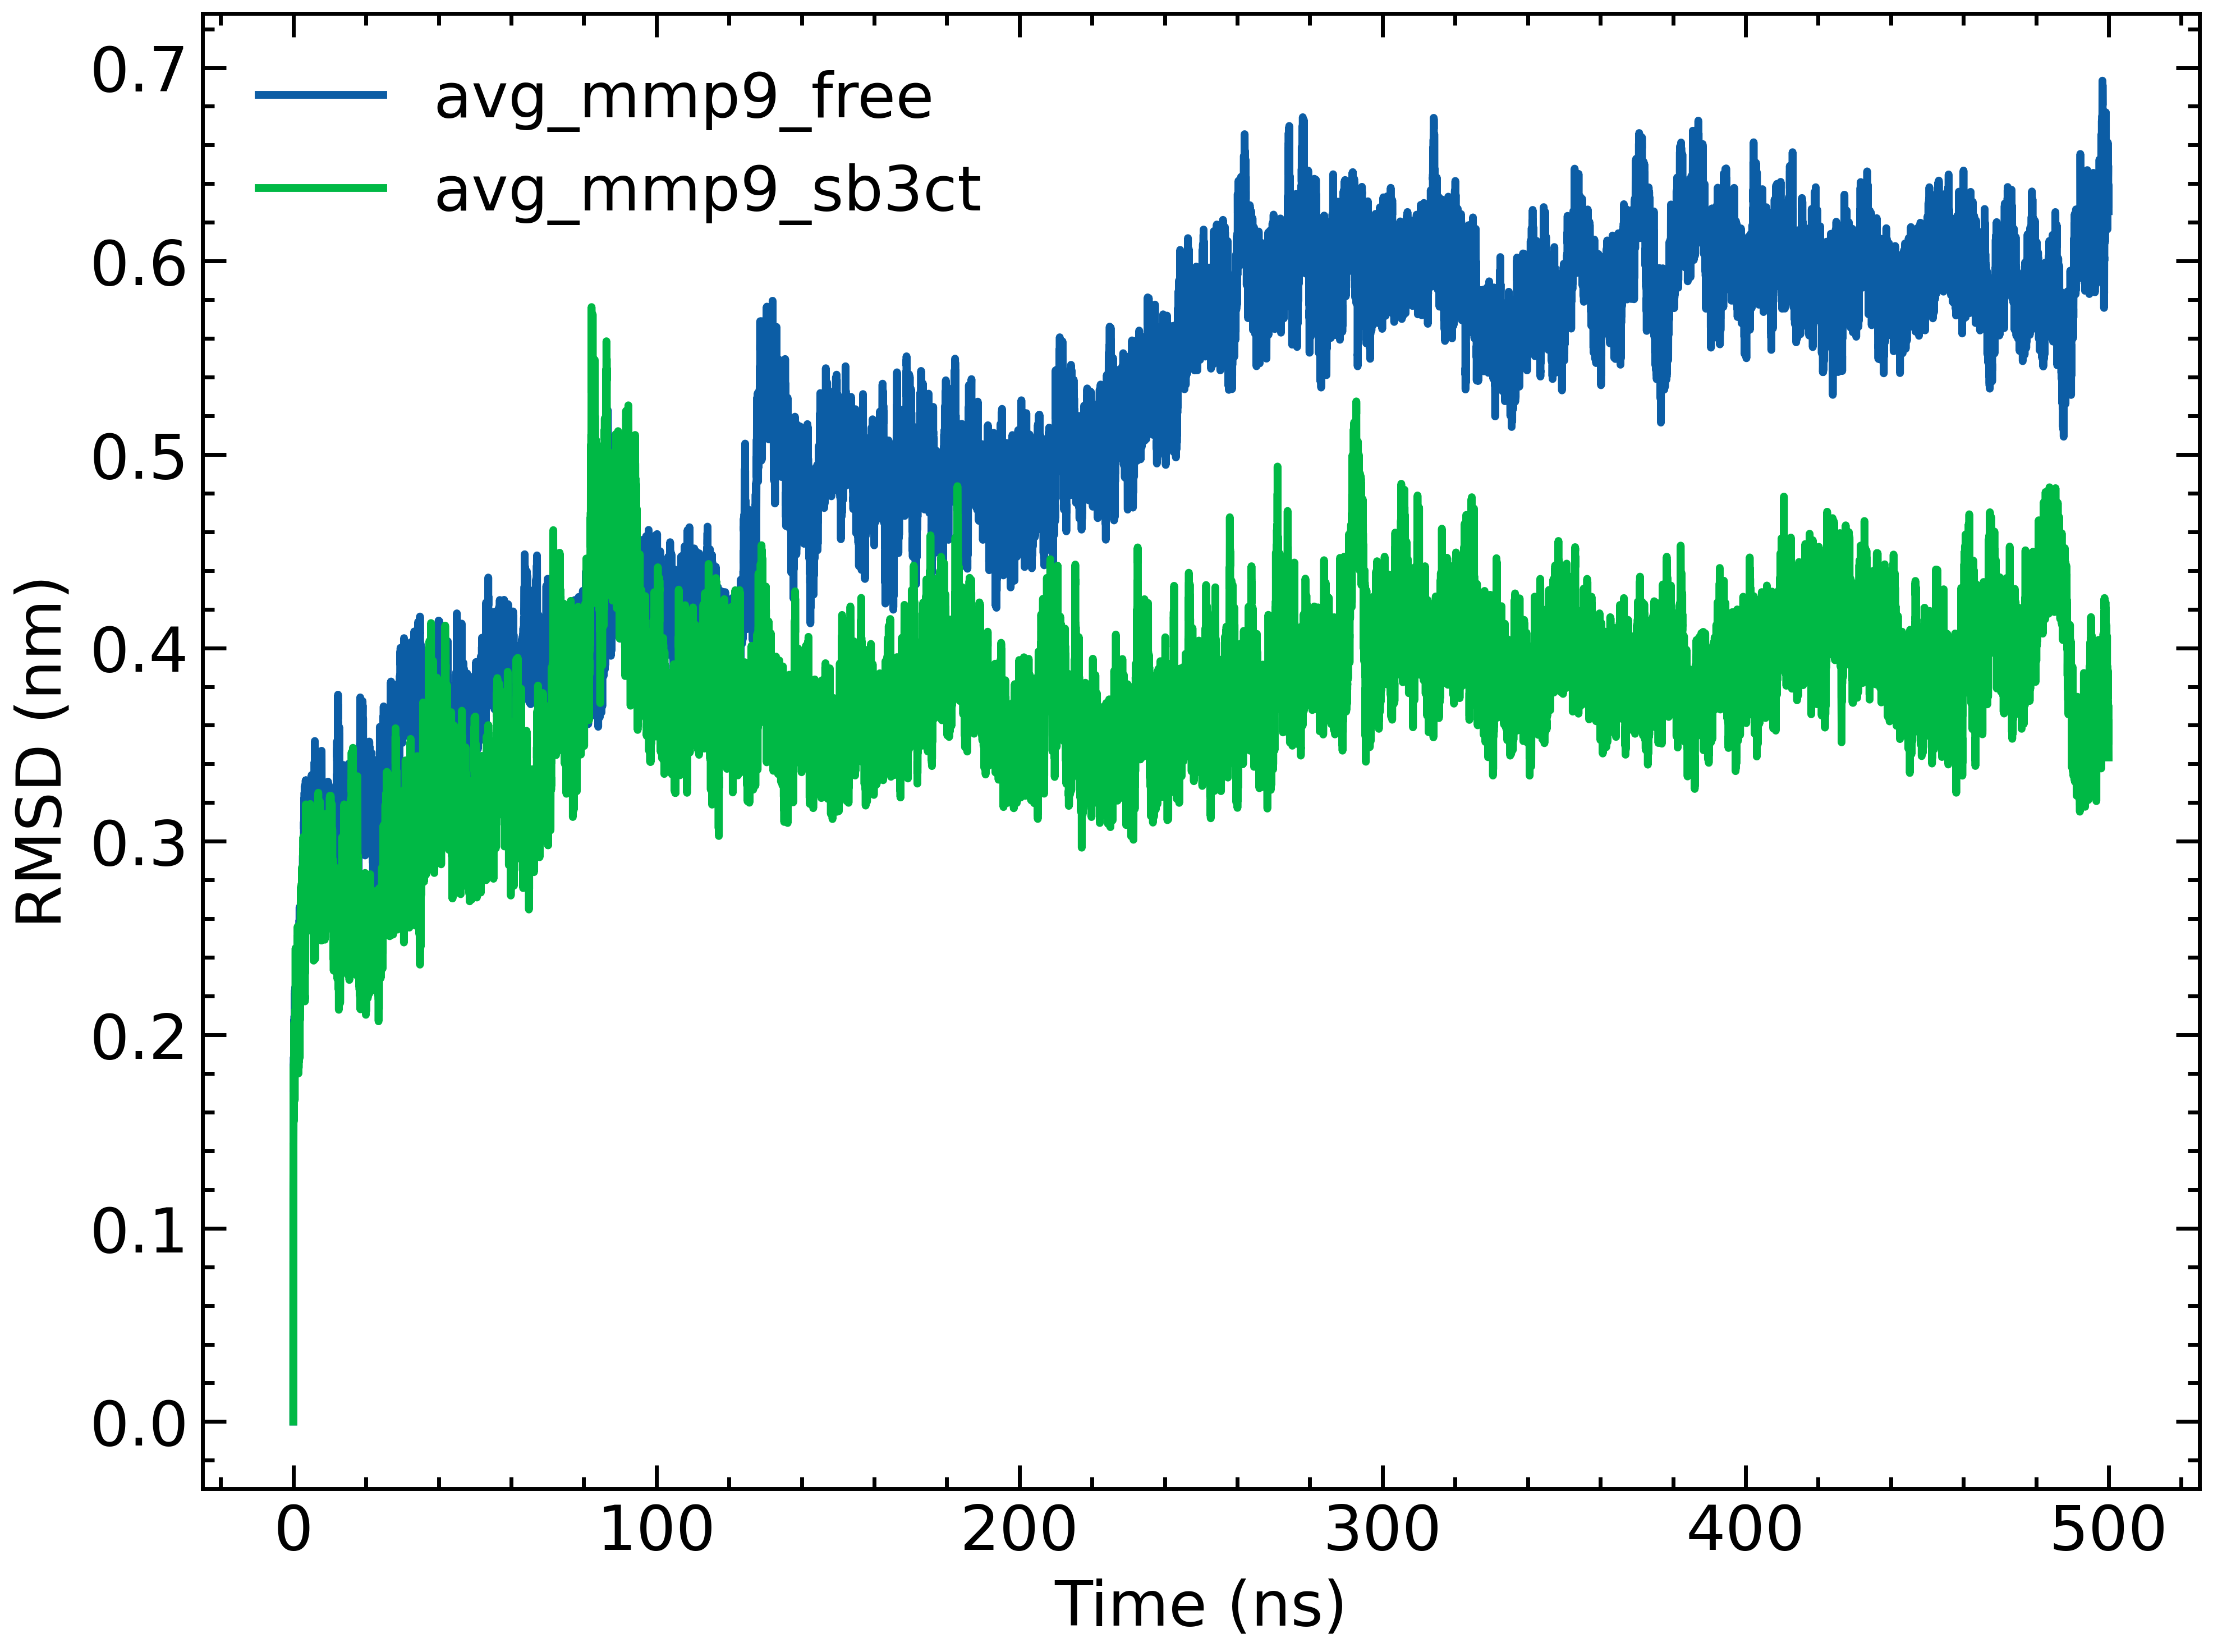

In [15]:

# Calculate the average RMSD for free MMP9
avg_rmsd_freemmp9 = np.mean([rmsd_dict_freemmp9[str(i)][:,1] for i in range(4)], axis=0)

# Calculate the average RMSD for MMP9-SB3CT
avg_rmsd_mmp9sb3ct = np.mean([rmsd_dict_mmp9sb3ct[str(i)][:,1] for i in range(2)], axis=0)

# Plot the average RMSD
plt.plot(rmsd_dict_freemmp9['0'][:,0]/1000, avg_rmsd_freemmp9/10, label='avg_mmp9_free')
plt.plot(rmsd_dict_freemmp9['0'][:,0]/1000, avg_rmsd_mmp9sb3ct/10, label='avg_mmp9_sb3ct')
plt.legend()
plt.tight_layout()
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (nm)');

## Radius of Gyration Calculation

In [16]:
from tqdm.notebook import tqdm

Rgyr_dict_freemmp9 = {}

for i,u in enumerate([mmp9_01, mmp9_02, mmp9_03, mmp9_04]):
	group = u.select_atoms('protein')		# change the atom selection for your specific system
	times = []
	Rgyr = []
	for ts in tqdm(u.trajectory):
		times.append(u.trajectory.time)
		Rgyr.append(group.radius_of_gyration())

	Rgyr_dict_freemmp9[str(i)] = np.vstack((times, Rgyr)).T

Rgyr_dict_mmp9sb3ct = {}

for i,u in enumerate([mmp9_sb3ct_01, mmp9_sb3ct_02]):
	group = u.select_atoms('protein')		# change the atom selection for your specific system
	times = []
	Rgyr = []
	for ts in tqdm(u.trajectory):
		times.append(u.trajectory.time)
		Rgyr.append(group.radius_of_gyration())

	Rgyr_dict_mmp9sb3ct[str(i)] = np.vstack((times, Rgyr)).T

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

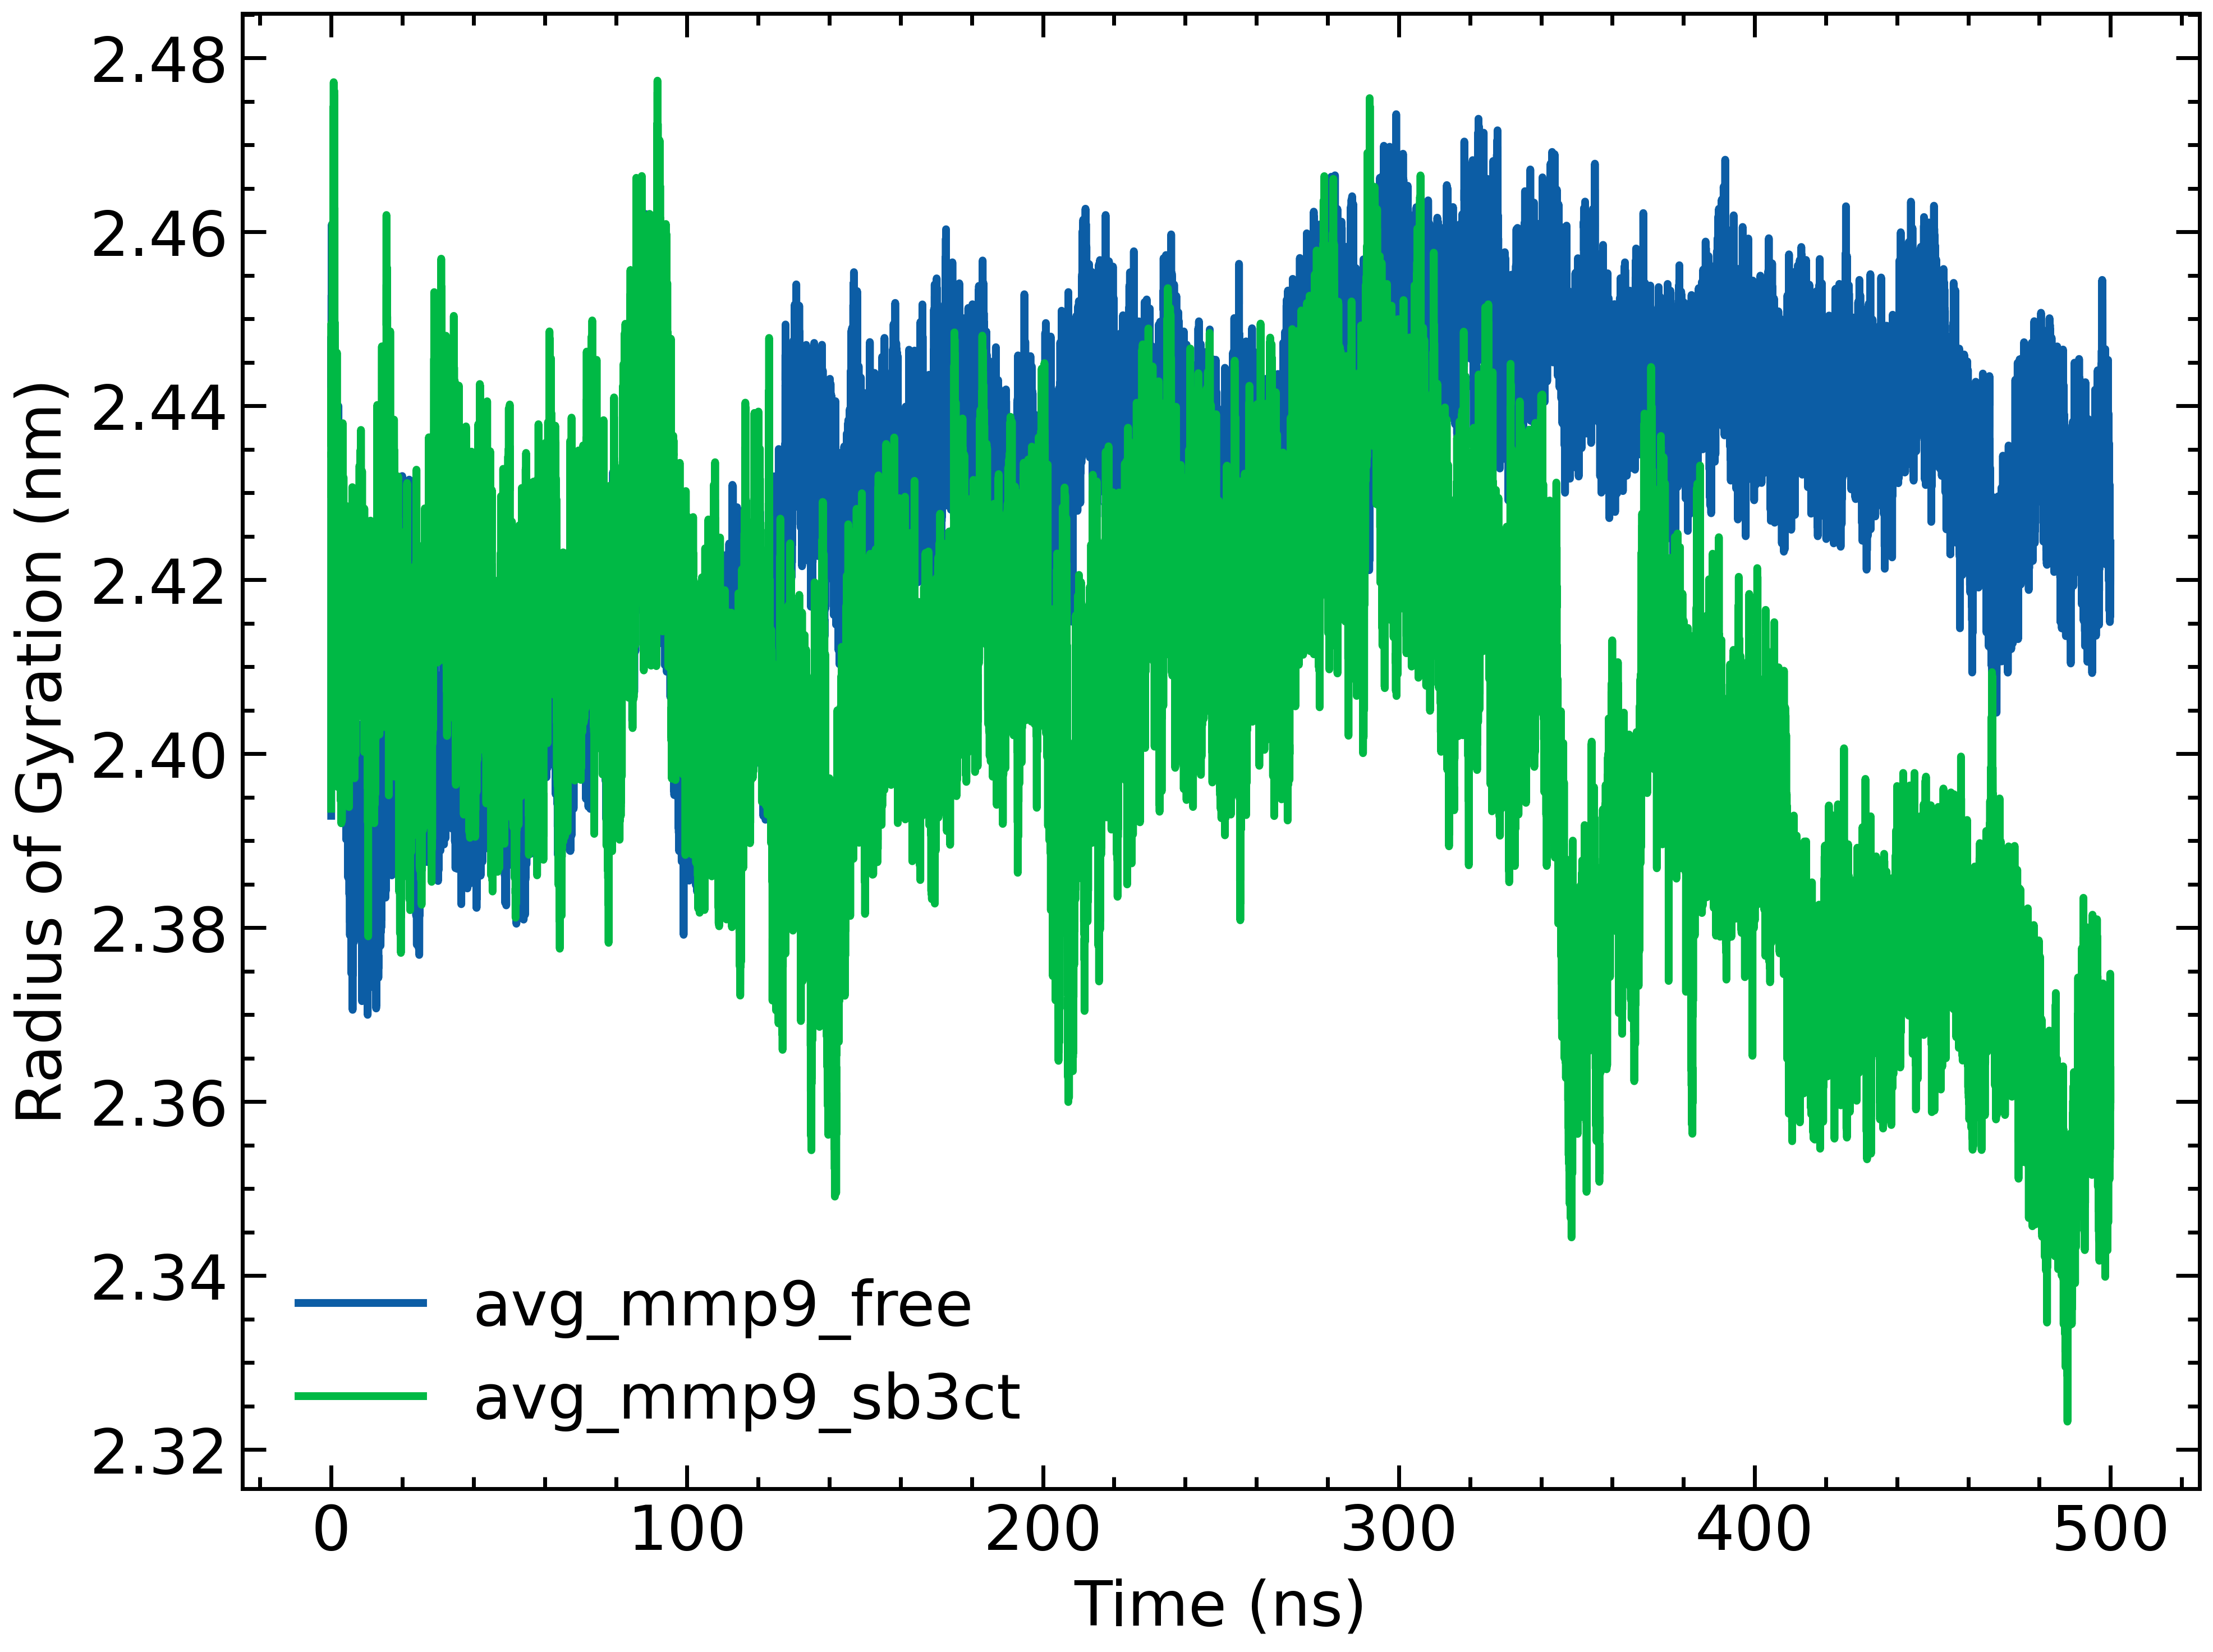

In [17]:
# Calculate the average Radius of Gyration for free MMP9
avg_rgyr_freemmp9 = np.mean([Rgyr_dict_freemmp9[str(i)][:,1] for i in range(4)], axis=0)

# Calculate the average Radius of Gyration for MMP9-SB3CT
avg_rgyr_mmp9sb3ct = np.mean([Rgyr_dict_mmp9sb3ct[str(i)][:,1] for i in range(2)], axis=0)

# Plot the average Radius of Gyration
plt.plot(Rgyr_dict_freemmp9['0'][:,0]/1000, avg_rgyr_freemmp9/10, label='avg_mmp9_free')
plt.plot(Rgyr_dict_mmp9sb3ct['0'][:,0]/1000, avg_rgyr_mmp9sb3ct/10, label='avg_mmp9_sb3ct')
plt.legend()
plt.tight_layout()
plt.xlabel('Time (ns)')
plt.ylabel('Radius of Gyration (nm)')
plt.show()

## RMSF Calculation

Between protein backbone and Carbon alphas.

In [18]:
rmsf_dict_freemmp9 = {}

for i,u in enumerate([mmp9_01, mmp9_02, mmp9_03, mmp9_04]):
    c_alphas = u.select_atoms('backbone and name CA')
    R_c_run = rms.RMSF(c_alphas).run(verbose=True)
    rmsf_dict_freemmp9[str(i)] = (c_alphas.resids, R_c_run.rmsf)
    
rmsf_dict_mmp9sb3ct = {}

for i,u in enumerate([mmp9_sb3ct_01, mmp9_sb3ct_02]):
    c_alphas = u.select_atoms('backbone and name CA')
    R_c_run = rms.RMSF(c_alphas).run(verbose=True)
    rmsf_dict_mmp9sb3ct[str(i)] = (c_alphas.resids, R_c_run.rmsf)

  0%|          | 0/50001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/gromacs/src/mdanalysis/package/MDAnalysis/analysis/rms.py:904: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

  0%|          | 0/50001 [00:00<?, ?it/s]

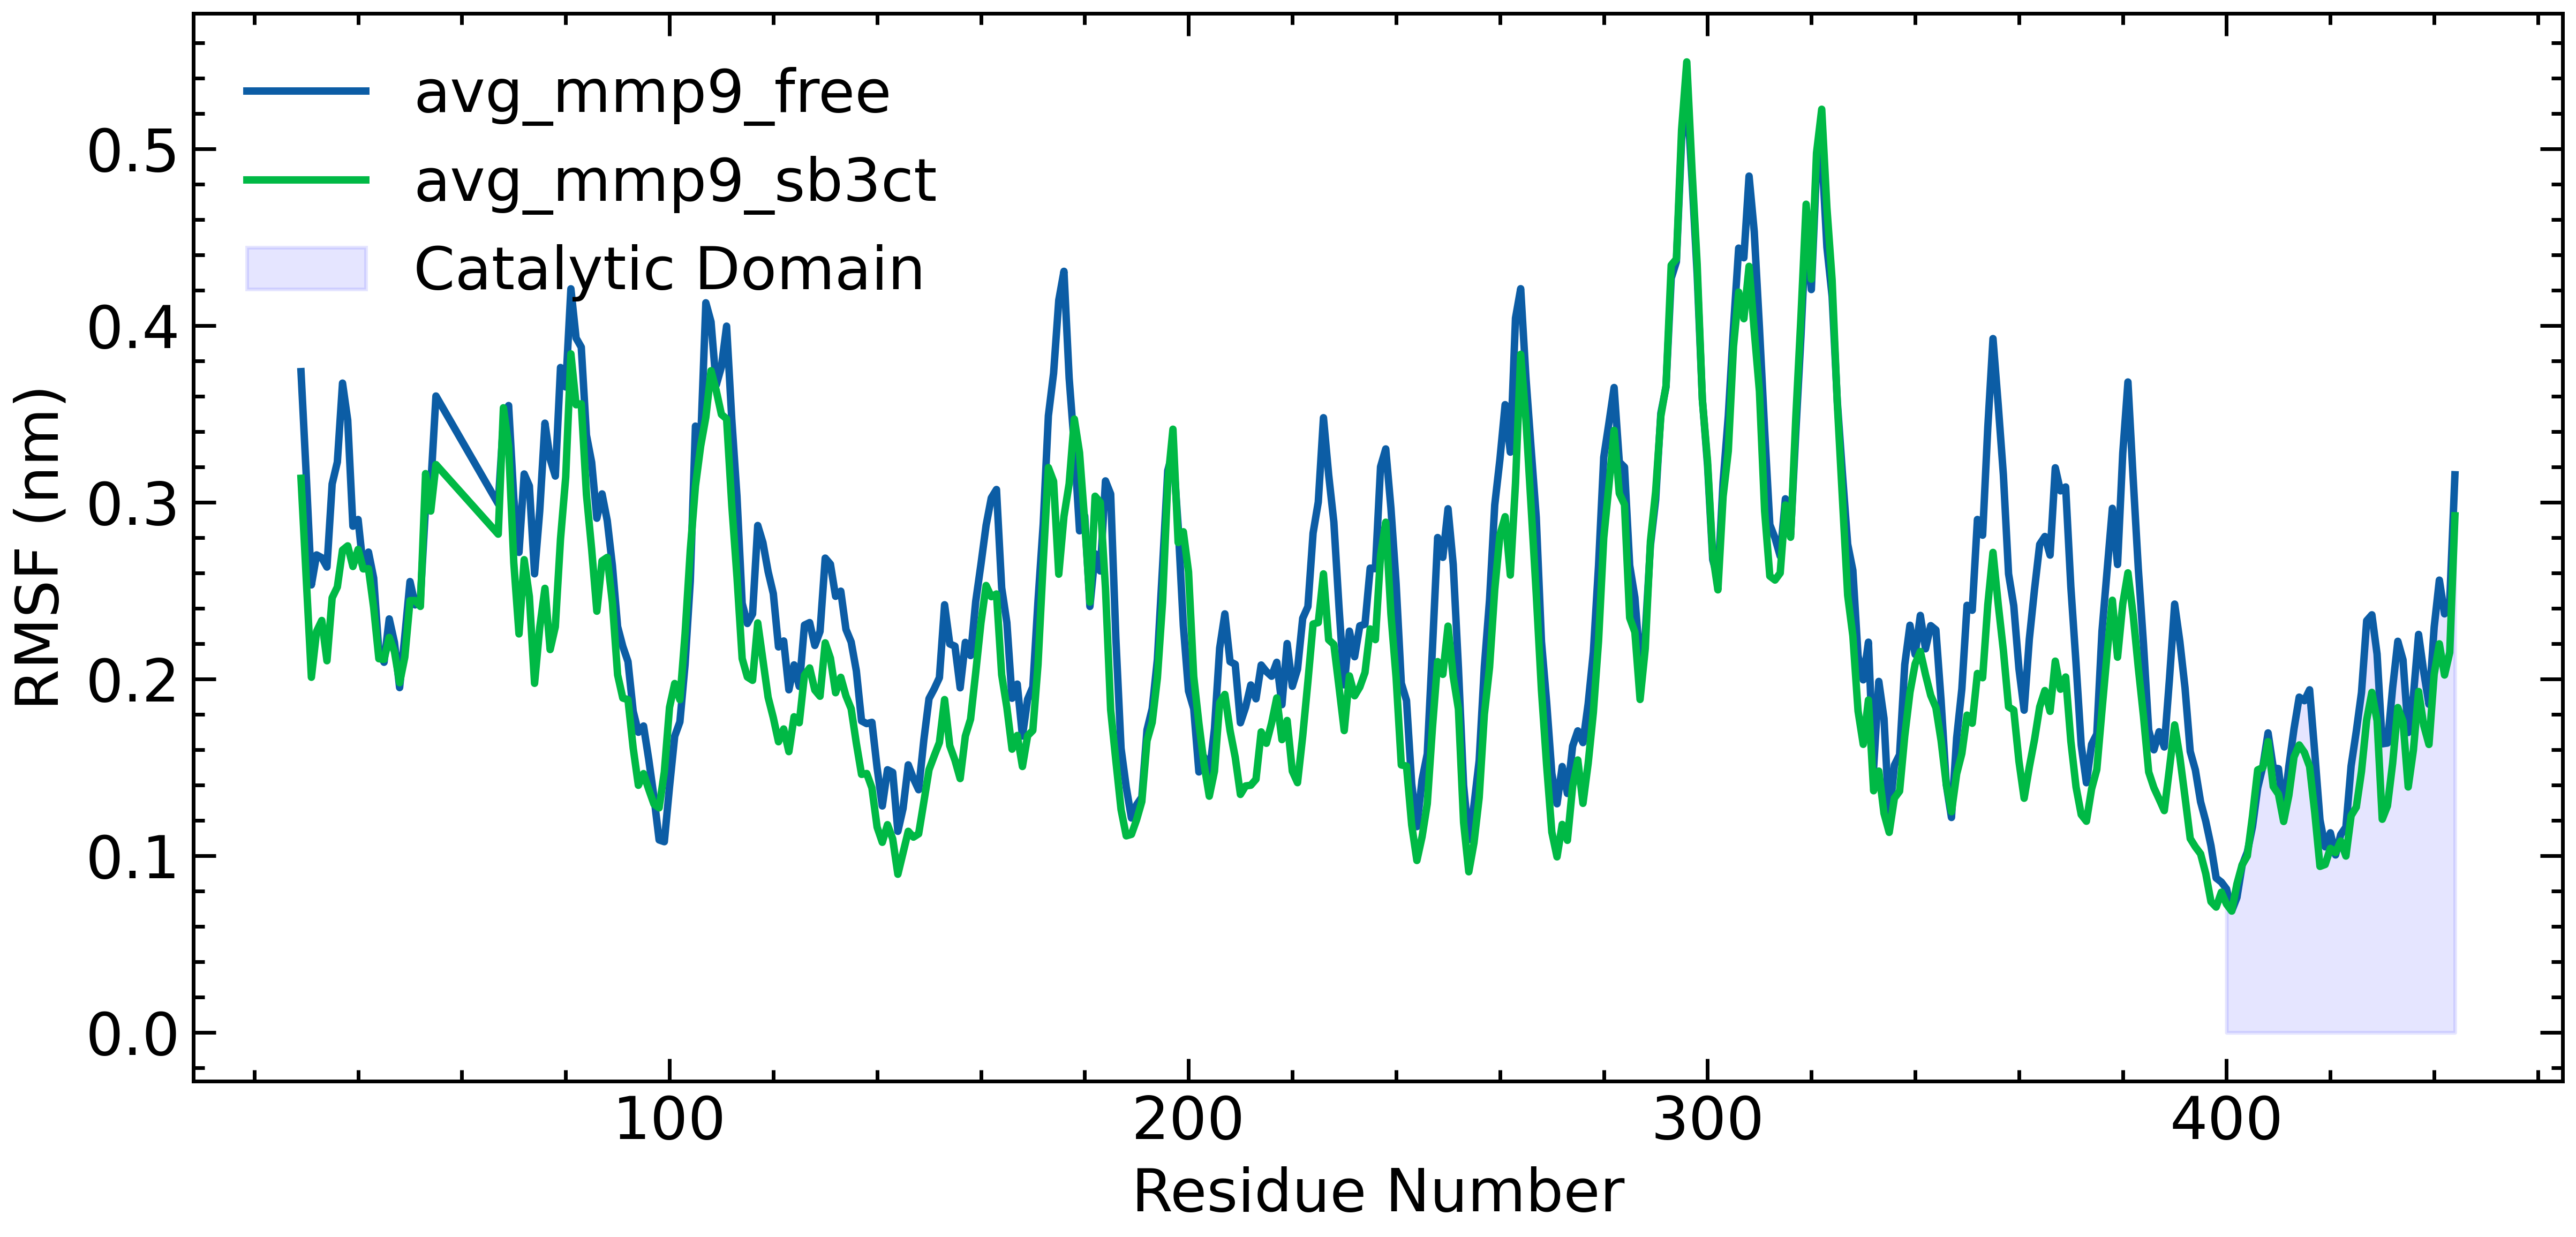

In [27]:
# Calculate the average RMSF for free MMP9
avg_rmsf_freemmp9 = np.mean([rmsf_dict_freemmp9[str(i)][1] for i in range(4)], axis=0)
avg_resids_freemmp9 = np.mean([rmsf_dict_freemmp9[str(i)][0] for i in range(4)], axis=0)

# Calculate the average RMSF for MMP9-SB3CT
avg_rmsf_mmp9sb3ct = np.mean([rmsf_dict_mmp9sb3ct[str(i)][1] for i in range(2)], axis=0)
avg_resids_mmp9sb3ct = np.mean([rmsf_dict_mmp9sb3ct[str(i)][0] for i in range(2)], axis=0)

# Plot the average RMSF vs average residue IDs
plt.figure(figsize=(10, 5))
plt.plot(avg_resids_freemmp9, avg_rmsf_freemmp9 / 10, label='avg_mmp9_free')
plt.plot(avg_resids_mmp9sb3ct, avg_rmsf_mmp9sb3ct / 10, label='avg_mmp9_sb3ct')
plt.xlabel('Residue Number')
plt.ylabel('RMSF (nm)')
plt.fill_between(avg_resids_freemmp9, avg_rmsf_freemmp9 / 10, where=(avg_resids_freemmp9 >= 400) & (avg_resids_freemmp9 <= 450), color='blue', alpha=0.1, label="Catalytic Domain")
plt.legend()
plt.tight_layout()
plt.show()

## H-bond analysis:

**Note:** As of today (20241222), the latest version of MDAnalysis (2.8) cannot read binary topology files (the ones with the `.tpr` extension) created by gromacs version 2024.4. Binary topology data is necessary for hydrogen bond analysis in `MDAnalysis` for some reason, so I am trying `MDTraj` instead.


In `MDTraj`, the Baker-Hubbard Hydrogen Bond Identification can be used, where the hydrogen bond is said to have formed if:

1. The angle $\theta_{dha}>2\pi/3$, *i.e.*, $120$ degrees, and
2. The distance $r_{ha}<0.25\;nm$. 
   
Here, $d$ means 'donor', 'h' means 'hydrogen', and 'a' means acceptor.
The donors considered by this method are NH and OH, and the acceptors considered are O and N.

Do not load the whole trajectory, as it will take up too much memory. Unlike `MDAnalysis`, `MDTraj` doesn't do lazy loads from disk, but fully operates in memory. This makes it faster, but memory-intensive.

So, we choose a 'stride' of, say, $60$ frames, and have `MDTraj` load every $60^{th}$ frame of the trajectory, then run the baker-hubbard algorithm.

In [20]:
stride = 60
total_frames = 50000
total_time_ns = 500

timestep  = (stride/total_frames) * total_time_ns

nframes = int(np.ceil(total_frames/stride))

timestep, nframes

(0.6, 834)

In [21]:
%%time
import numpy as np
import mdtraj as md


xtcfile='1l6j_run1/md500_compact_compact.xtc'
topfile='1l6j_run1/md500_start.pdb'

full_traj_run1 = md.load_xtc(xtcfile, stride=stride, top=topfile)
sb3ct_atoms = full_traj_run1.topology.select('resname LIG')
hbonds = md.baker_hubbard(full_traj_run1, periodic=False, freq=0.01)
label = lambda hbond : '%s - %s ... %s' % ( full_traj_run1.topology.atom(hbond[0]),\
                                            full_traj_run1.topology.atom(hbond[1]),\
                                            full_traj_run1.topology.atom(hbond[2]))
sb3ct_hbonds_run1 = []
for hbond in hbonds:
    d,h,a = hbond
    if d in sb3ct_atoms or a in sb3ct_atoms:
        sb3ct_hbonds_run1.append(hbond)
        print(label(hbond))

sb3ct_hbonds_run1 = np.array(sb3ct_hbonds_run1)

ARG424-N - ARG424-H ... LIG502-O
ARG424-N - ARG424-H ... LIG502-O1
CPU times: user 24.7 s, sys: 3.15 s, total: 27.8 s
Wall time: 29.2 s


In [22]:
%%time
import numpy as np
import mdtraj as md


xtcfile='1l6j_run2/md500_compact_compact.xtc'
topfile='1l6j_run2/md500_start.pdb'

full_traj_run2 = md.load_xtc(xtcfile, stride=stride, top=topfile)
sb3ct_atoms = full_traj_run2.topology.select('resname LIG')
hbonds = md.baker_hubbard(full_traj_run2, periodic=False, freq=0.01)
label = lambda hbond : '%s - %s ... %s' % ( full_traj_run2.topology.atom(hbond[0]),\
                                            full_traj_run2.topology.atom(hbond[1]),\
                                            full_traj_run2.topology.atom(hbond[2]))
sb3ct_hbonds_run2 = []
for hbond in hbonds:
    d,h,a = hbond
    if d in sb3ct_atoms or a in sb3ct_atoms:
        sb3ct_hbonds_run2.append(hbond)
        print(label(hbond))

sb3ct_hbonds_run2 = np.array(sb3ct_hbonds_run2)

ARG424-N - ARG424-H ... LIG502-O
ARG424-N - ARG424-H ... LIG502-O1
THR426-OG1 - THR426-HG1 ... LIG502-O
CPU times: user 24 s, sys: 750 ms, total: 24.7 s
Wall time: 26.4 s


So, according to `MDTraj` Baker-Hubbard hbond detector, there are only $3$ hydrogen bonds that form at more than a frequency of `freq=` $0.01$ in the trajectory frames. In run2, an extra bond is detected, *viz.* `THR426-OG1 - THR426-HG1 ... LIG502-O`


Calculate the distances and angles for each hbond.

In [28]:
da_distances_run1 = md.compute_distances(full_traj_run1, sb3ct_hbonds_run1[:, [1,2]], periodic=False)
da_angles_run1 = md.compute_angles(full_traj_run1, sb3ct_hbonds_run1, periodic=False)

Let us get the number of hbonds between protein and ligand.

In [29]:
distance_met_run1 = da_distances_run1 < 0.25
angle_met_run1 = da_angles_run1 > 2 * np.pi/3
hbond_met_run1 = np.logical_and(distance_met_run1, angle_met_run1)
num_hbonds_run1 = np.sum(hbond_met_run1, axis=1)

In [30]:
da_distances_run2 = md.compute_distances(full_traj_run2, sb3ct_hbonds_run2[:, [1,2]], periodic=False)
da_angles_run2 = md.compute_angles(full_traj_run2, sb3ct_hbonds_run2, periodic=False)

In [31]:
distance_met_run2 = da_distances_run2 < 0.25
angle_met_run2 = da_angles_run2 > 2 * np.pi/3
hbond_met_run2 = np.logical_and(distance_met_run2, angle_met_run2)
num_hbonds_run2 = np.sum(hbond_met_run2, axis=1)

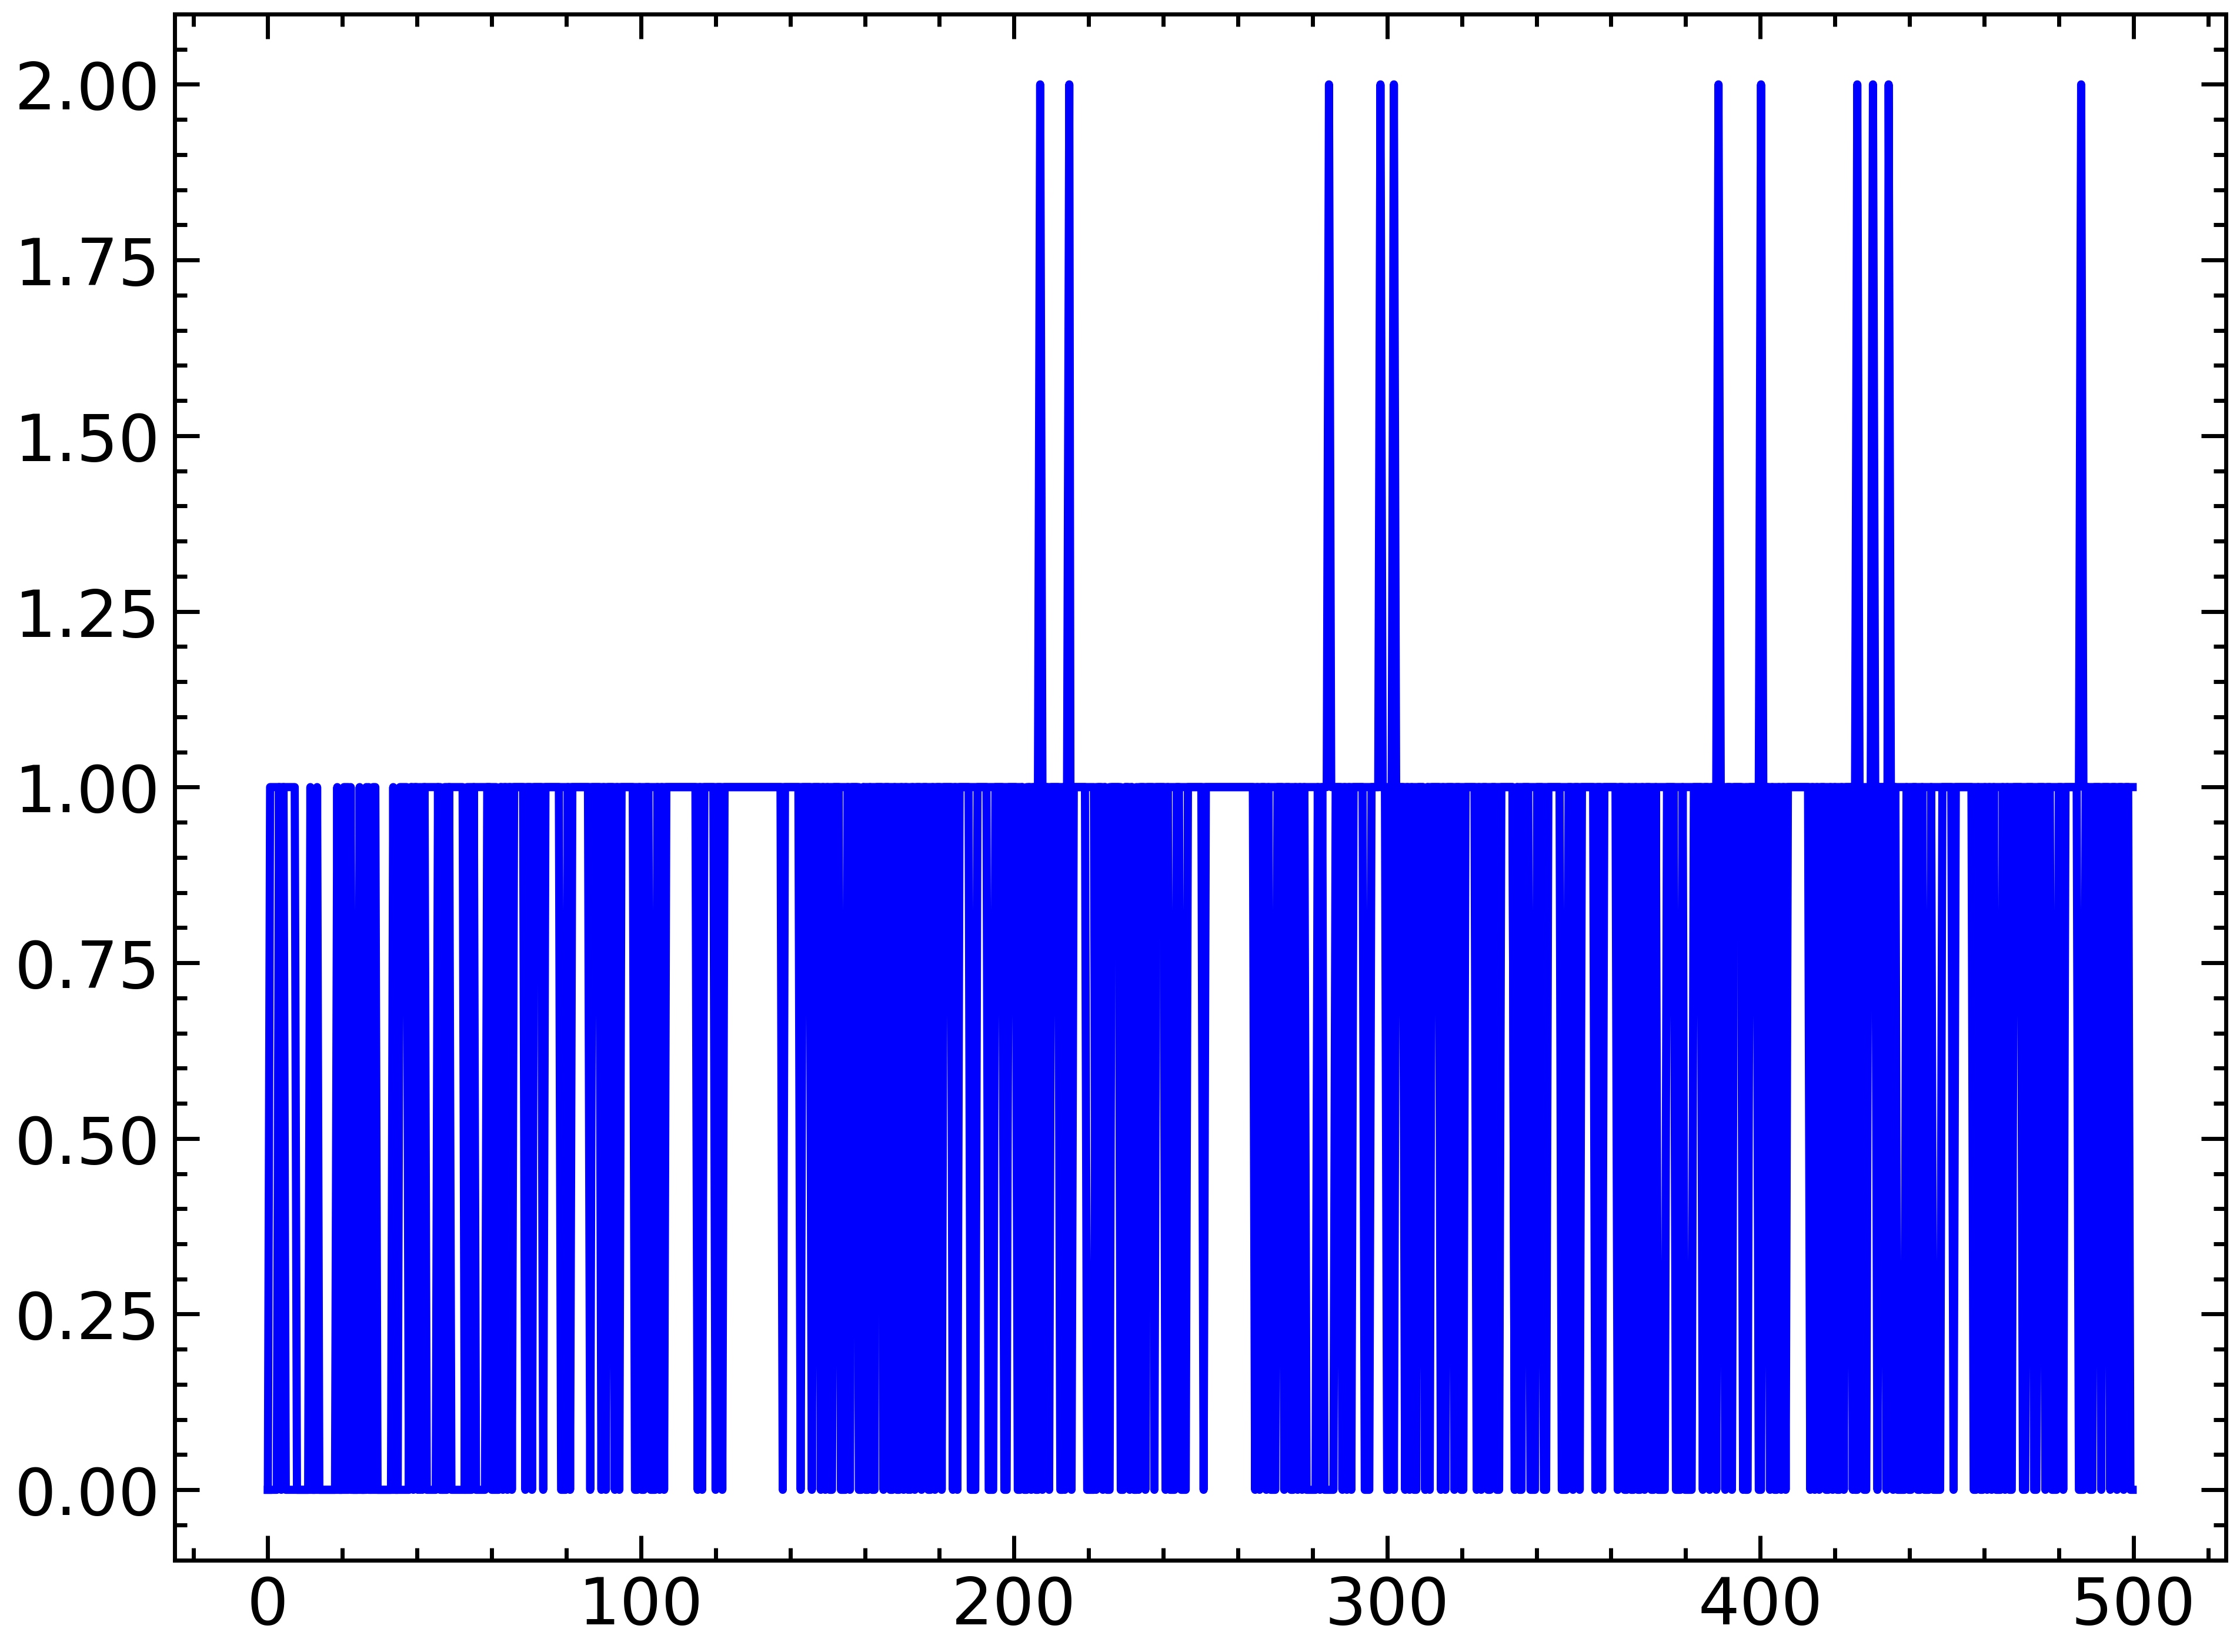

In [32]:
plt.plot(full_traj_run1.time/1000, num_hbonds_run1,'b-')
plt.plot(full_traj_run2.time/1000, num_hbonds_run2,'b-')


## Plots

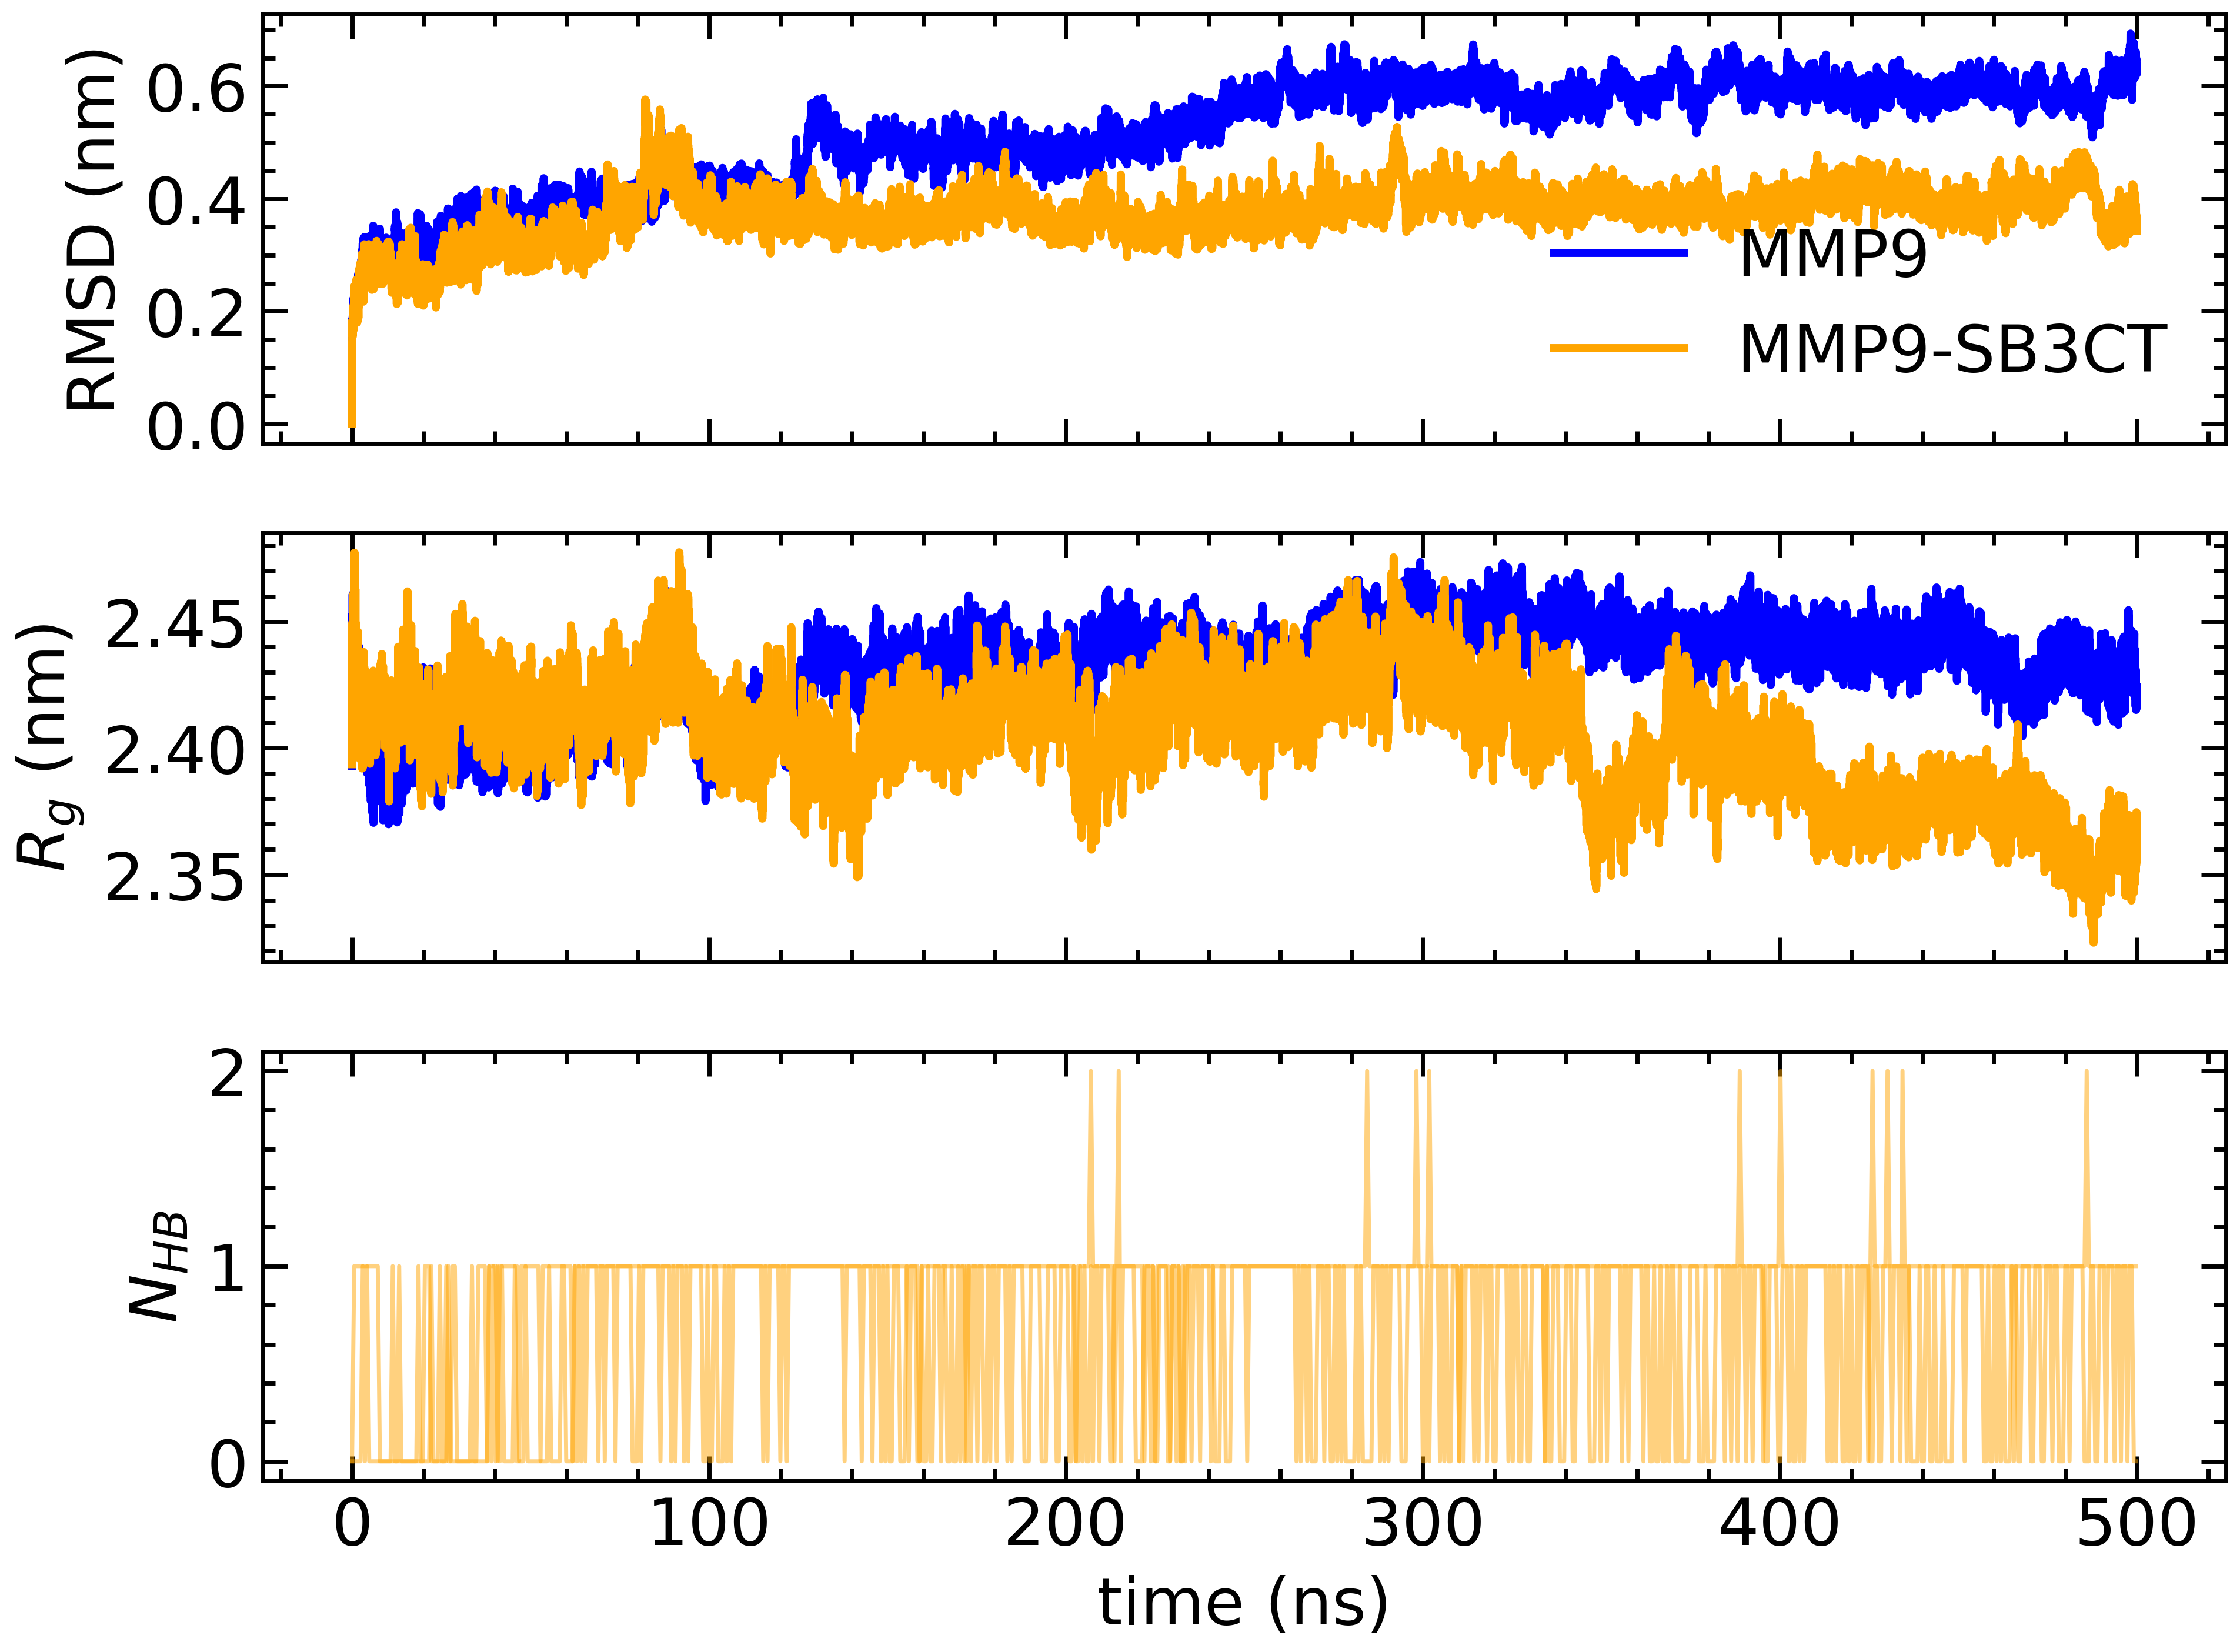

In [35]:
npanels = 3
fig, axs = plt.subplots(npanels,1, sharex=True, tight_layout=True)

ax_rmsd = axs[0]
ax_rmsd.set_ylabel(r'RMSD (nm)');

ax_rmsd.plot(rmsd_dict_freemmp9['0'][:,0]/1000, avg_rmsd_freemmp9/10, label='MMP9', color='blue')
ax_rmsd.plot(rmsd_dict_freemmp9['0'][:,0]/1000, avg_rmsd_mmp9sb3ct/10, label='MMP9-SB3CT', color='orange')
ax_rmsd.set_yticks(np.arange(0, 0.7, 0.2))

ax_rmsd.legend()

ax_rg = axs[1]

ax_rg.plot(Rgyr_dict_freemmp9['0'][:,0]/1000, avg_rgyr_freemmp9/10, color='blue', label='avg_mmp9_free')
ax_rg.plot(Rgyr_dict_mmp9sb3ct['0'][:,0]/1000, avg_rgyr_mmp9sb3ct/10, color='orange', label='avg_mmp9_sb3ct')
ax_rg.set_ylabel(r'$R_g$ (nm)');

ax_bonds = axs[2]
ax_bonds.set_xlabel(r'time (ns)');

ax_bonds.plot(timestep * np.arange(nframes), num_hbonds_run1, lw=1, label="MMP9-SB3CT", alpha=0.5,color='orange')
ax_bonds.plot(timestep * np.arange(nframes), num_hbonds_run2, lw=1, label="MMP9-SB3CT", alpha=0.5,color='orange')


ax_bonds.set_ylabel(r"$N_{HB}$")
plt.savefig("time-series-plots.png", dpi=600)
plt.show()

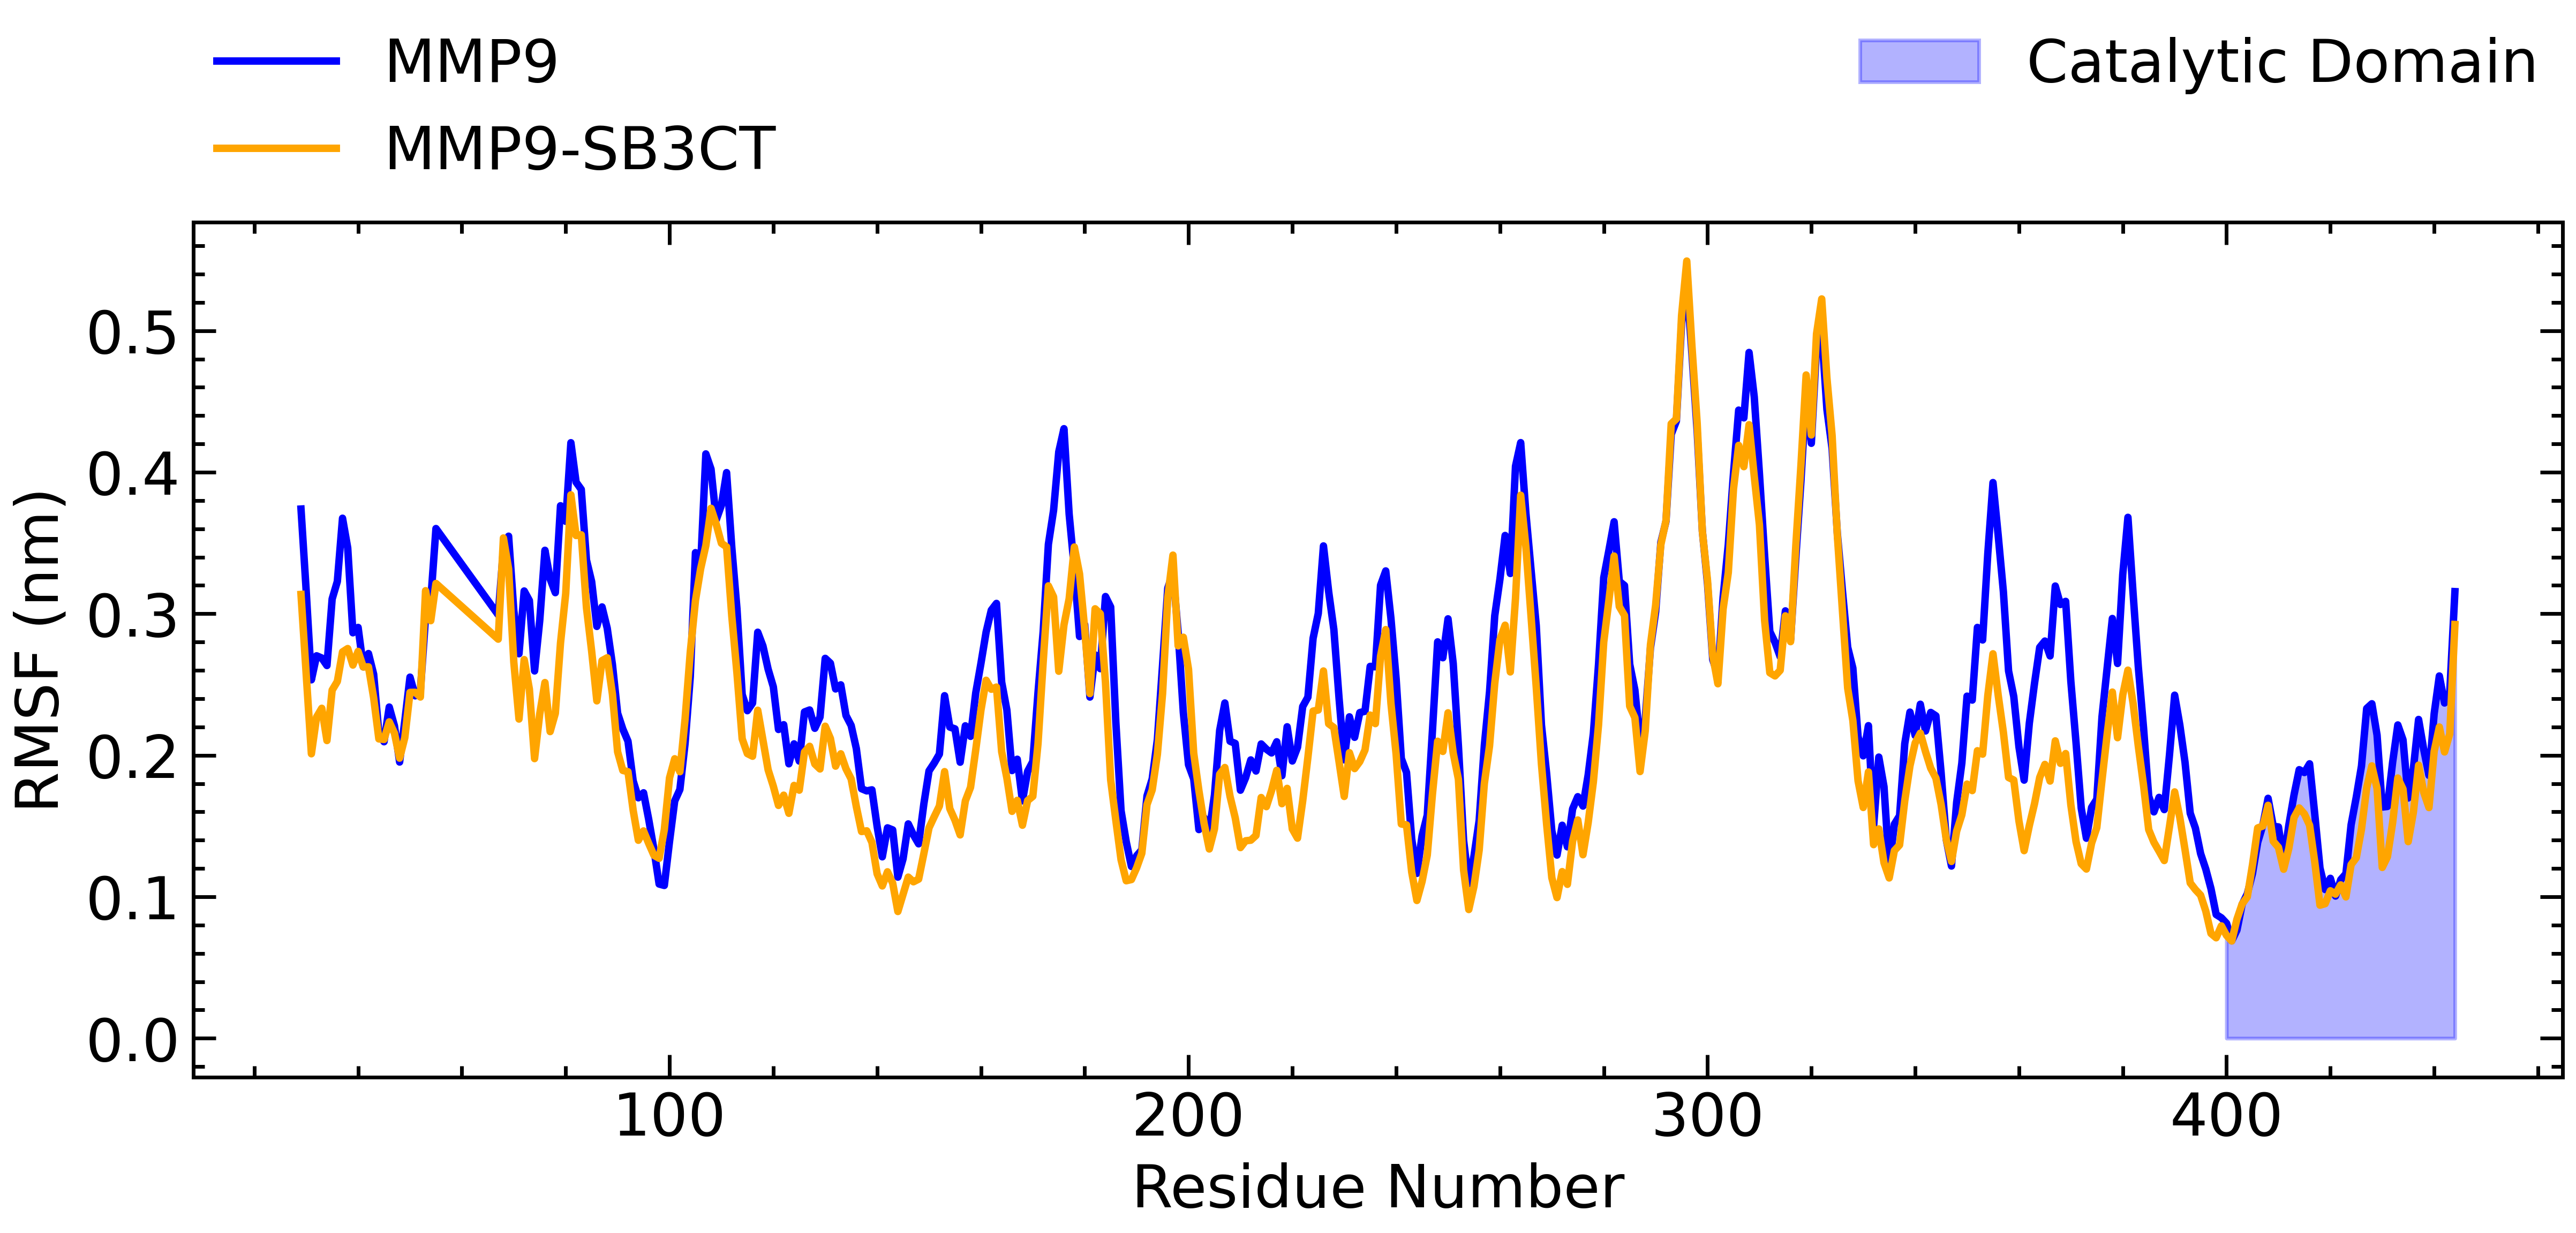

In [38]:
# Calculate the average RMSF for free MMP9
avg_rmsf_freemmp9 = np.mean([rmsf_dict_freemmp9[str(i)][1] for i in range(4)], axis=0)
avg_resids_freemmp9 = np.mean([rmsf_dict_freemmp9[str(i)][0] for i in range(4)], axis=0)

# Calculate the average RMSF for MMP9-SB3CT
avg_rmsf_mmp9sb3ct = np.mean([rmsf_dict_mmp9sb3ct[str(i)][1] for i in range(2)], axis=0)
avg_resids_mmp9sb3ct = np.mean([rmsf_dict_mmp9sb3ct[str(i)][0] for i in range(2)], axis=0)

# Plot the average RMSF vs average residue IDs
plt.figure(figsize=(10, 5))
plt.plot(avg_resids_freemmp9, avg_rmsf_freemmp9 / 10, label='MMP9', color='blue')
plt.plot(avg_resids_mmp9sb3ct, avg_rmsf_mmp9sb3ct / 10, label='MMP9-SB3CT', color='orange')
plt.xlabel('Residue Number')
plt.ylabel('RMSF (nm)')
plt.fill_between(avg_resids_freemmp9, avg_rmsf_freemmp9 / 10, where=(avg_resids_freemmp9 >= 400) & (avg_resids_freemmp9 <= 450), color='blue', alpha=0.3, label="Catalytic Domain")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncols=2, mode="expand", borderaxespad=0.);
plt.tight_layout()
plt.savefig("rmsf-plot.png", dpi=600)
plt.show()

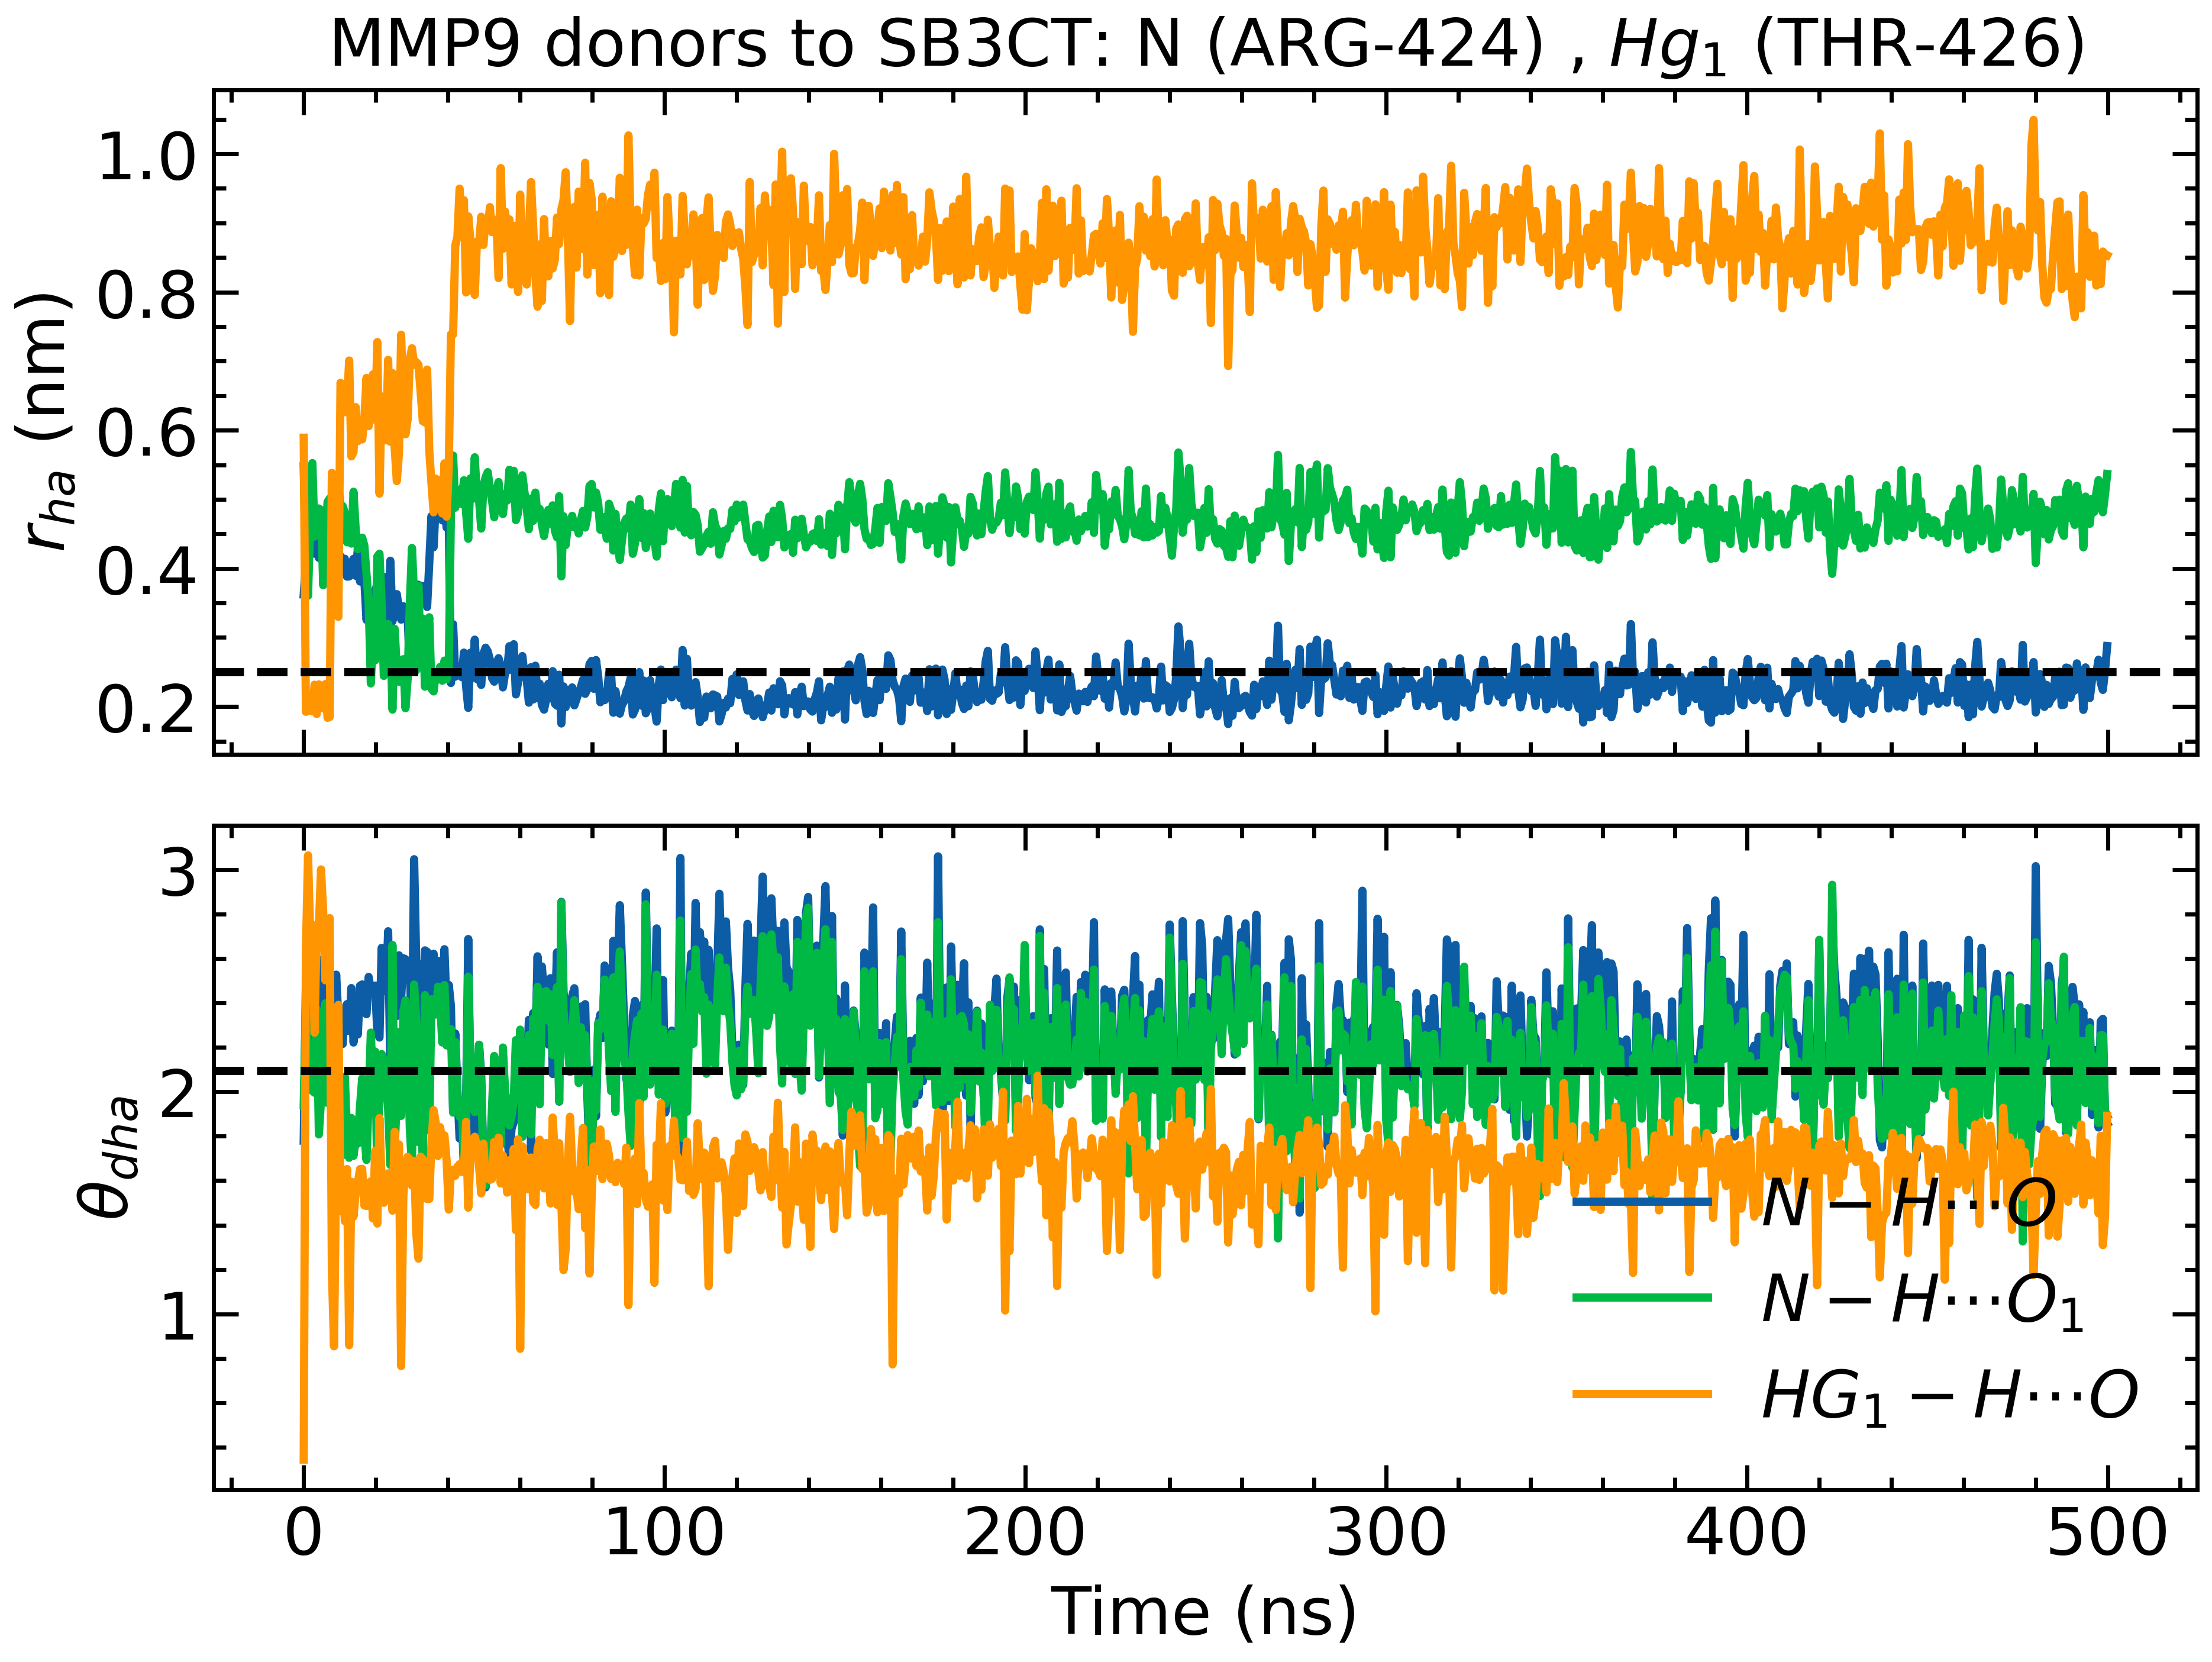

In [47]:
fig, axs = plt.subplots(2, 1, sharex=True)

# Plot for run1 distances. I have excluded this for now
#axs[0, 0].plot(timestep * np.arange(nframes), da_distances_run1[:,0], label=r'$N-H\cdots O$')
#axs[0, 0].plot(timestep * np.arange(nframes), da_distances_run1[:,1], label=r'$N-H\cdots O_1$')
#axs[0, 0].axhline(0.25, color='black', linestyle='--')
#axs[0, 0].set_ylabel(r'$r_{ha}$ (nm)')
#axs[0, 0].set_title('MMP9 donor to SB3CT:  N (ARG-424)')
#axs[0, 0].legend()

# Plot for run1 angles
#axs[1, 0].plot(timestep * np.arange(nframes), da_angles_run1[:,0], label=r'$N-H\cdots O$')
#axs[1, 0].plot(timestep * np.arange(nframes), da_angles_run1[:,1], label=r'$N-H\cdots O_1$')
#axs[1, 0].axhline(2 * np.pi/3, color='black', linestyle='--')
#axs[1, 0].set_ylabel(r'$\theta_{dha}$')
#axs[1, 0].set_xlabel('Time (ns)')
#axs[1, 0].legend()

# Plot for run2 distances
axs[0].plot(timestep * np.arange(nframes), da_distances_run2[:,0], label=r'$N-H\cdots O$')
axs[0].plot(timestep * np.arange(nframes), da_distances_run2[:,1], label=r'$N-H\cdots O_1$')
axs[0].plot(timestep * np.arange(nframes), da_distances_run2[:,2], label=r'$HG_1-H\cdots O$')
axs[0].axhline(0.25, color='black', linestyle='--')
axs[0].set_ylabel(r'$r_{ha}$ (nm)')
axs[0].set_title(r'MMP9 donors to SB3CT: N (ARG-424) , $Hg_1$ (THR-426)')
#axs[0].legend()

# Plot for run2 angles
axs[1].plot(timestep * np.arange(nframes), da_angles_run2[:,0], label=r'$N-H\cdots O$')
axs[1].plot(timestep * np.arange(nframes), da_angles_run2[:,1], label=r'$N-H\cdots O_1$')
axs[1].plot(timestep * np.arange(nframes), da_angles_run2[:,2], label=r'$HG_1-H\cdots O$')
axs[1].axhline(2 * np.pi/3, color='black', linestyle='--')
axs[1].set_ylabel(r'$\theta_{dha}$')
axs[1].set_xlabel('Time (ns)')
axs[1].legend()

plt.tight_layout()
plt.savefig("hbond-plot.png", dpi=600)
plt.show()

As can be seen from the above analysis, there is basically just one hbond being consistently detected, namely, $N (424-ARG)-H\cdots O$. The other two, namely $N (424-ARG)-H\cdots O_1$ and $HG_1 (426-THR)-H\cdots O$, are intermittent and go away at long times. I think that we can ignore it.

## Principal Component Analysis

We will do the PCA two ways: First using `MDAnslysis`, then using `gromacs` tools. Tentative comparison yields quantitatively better results for `gromacs` than `MDAnalysis`, as seen below.

***Notabene*** MUST USE BACKBONE AND LIGAND AS SELECTIONS, SINCE WE NEED TO LOOK AT LIGAND CONFORMATIONAL CHANGES AS WELL.

### PCA using MDAnalysis
Following the PCA HOWTO in the [MDAnalysis userguide](https://userguide.mdanalysis.org/stable/examples/analysis/reduced_dimensions/pca.html)

***Update*** I removed this analysis in 20241229, as it was too slow, even with parallel processing, and yielded quantitatively poor results gompared to `gromacs`.

### PCA via GROMACS tools

Firt, create an index for backbone, ligand and zinc

`gmx make_ndx -f md500.gro -o md500_pca.ndx` Choose backbone OR LIG OR ZN2

Then, we need to dump the first frame of MD simulation as pdb file (unless that has already been done).

`gmx trjconv -s md.tpr -f md500_compact_compact.xtc -o start.pdb -dump 0`

Selections should be the index just created.

Then, generating the eigenvectors

`gmx covar -s start.pdb -f md_center.xtc -o eigenvalues.xvg -v eigenvectors.trr -xpma covapic.xpm -n md500_pca.ndx`
Selections should be the index just created.

Followed by `gmx anaeig` to generate pc1 and pc2 files

`gmx anaeig -f md500_compact_compact.xtc -s start.pdb -v eigenvectors.trr -last 1 -proj pc1.xvg -n md500_pca.ndx`

`gmx anaeig -f md500_compact_compact.xtc -s start.pdb -v eigenvectors.trr -first 2 -last 2 -proj pc2.xvg -n md500_pca.ndx`

Use these two xvg files (pc1.xvg and pc2.xvg) to generate the following plots.

In [1]:
import numpy as np

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for RMSD and radius of gyration XVG files
pc1_file = '1l6j_run2/pc1.xvg'
pc2_file = '1l6j_run2/pc2.xvg'

# Read data from XVG files with skip headers
t1, pc1_data = read_xvg(pc1_file, skip_header=24)  # Adjust skip_header based on your file format
t2, pc2_data = read_xvg(pc2_file, skip_header=24)  # Adjust skip_header based on your file format

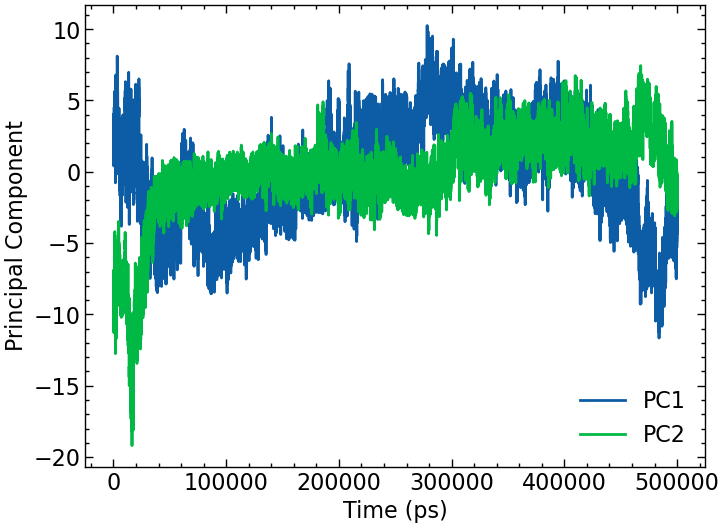

In [2]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])
plt.plot(t1, pc1_data, label='PC1')
plt.plot(t2, pc2_data, label='PC2')
plt.xlabel('Time (ps)')
plt.ylabel('Principal Component')
plt.legend()

For PCA with respect to energy, first

`paste pc1.xvg pc2.xvg | awk '{print $1, $2, $4}' > PC1PC2.xvg`

Then, use this PC1PC2.xvg file to generate an xpm file

`gmx sham -f PC1PC2.xvg -ls FES.xpm`

Then use the following `xpm2txt.py` script to convert the .xpm file into .dat file:


In [ ]:
#!/usr/bin/env python3

import sys

"""
Utility tool to convert xpm files generated by GROMACS to a 3-column text file.
"""

USAGE = "USAGE: xpm2txt.py -f <input xpm file> -o <output txt file> [-s]\n"
USAGE += "Options:\n"
USAGE += "\t-s\t(int)\tSorts the output by a given column"
USAGE += "\n"  # always keep this line

# Parse arguments
read_input, read_output, sort = False, False, False
xpm_file, out_file, column_sort = None, None, None
for arg in sys.argv[1:]:
    if read_input:
        read_input = False
        xpm_file = arg
    elif read_output:
        read_output = False
        out_file = arg
    elif sort:
        sort = False
        column_sort = int(arg)
    if arg.startswith("-"):
        if arg == "-f":
            read_input = True
            continue
        elif arg == "-o":
            read_output = True
            continue
        elif arg == "-s":
            sort = True
        else:
            print(USAGE)
            sys.stderr.write('ERROR: Option not recognized: %s\n' % arg)
            sys.exit(1)

if not xpm_file:
    print(USAGE)
    sys.stderr.write('ERROR: You forgot to provide an input file.\n')
    sys.exit(1)
if not out_file:
    out_file = "out.txt"

# Parse XPM file
with open(xpm_file) as xpm_handle:
    xpm_data = []
    x_axis, y_axis = [], []
    letter_to_value = {}
    for line in xpm_handle:
        if line.startswith("/* x-axis"):
            x_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith("/* y-axis"):
            y_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith('"') and x_axis and y_axis:  # Read data
            xpm_data.insert(0, line.strip().strip(',')[1:-1])

        if line.startswith('"') and len(line.split()) > 4:
            letter = line.split()[0][1:]
            value = float(line.split()[-2][1:-1])
            letter_to_value[letter] = value

# Match x/y/data
txt_values = []
for y_index, data_value in enumerate(xpm_data):
    y_value = y_axis[y_index]
    for x_index, x_value in enumerate(x_axis):
        txt_values.append([x_value, y_value, letter_to_value[data_value[x_index]]])

# Apply sorting if requested
if column_sort:
    try:
        txt_values.sort(key=lambda x: x[column_sort - 1])
    except IndexError:
        print(USAGE)
        sys.stderr.write('ERROR: Column not found (%s)\n' % (column_sort))
        sys.exit(1)

# Print to file
with open(out_file, 'w') as out_handle:
    for x, y, z in txt_values:
        out_handle.write("%3.5f\t%3.5f\t%3.5f\n" % (x, y, z))

Use this above-mentioned script as

`./xpm2txt.py -f FES.xpm -o FEL.dat`

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Read input data from a file
input_file = '1l6j_run2/FEL.dat'
data = np.loadtxt(input_file)  # Assuming input data file ha6s PC1, PC2, and hbonds columns

PC1 = data[:, 0]
PC2 = data[:, 1]
free_energy = data[:, 2]


# Function to read XVG file and extract data
def read_xvg(file_path):
    data = np.genfromtxt(file_path, skip_header=18)  # Adjust skip_header based on your XVG file format
    xpoints = data[:, 0]
    ypoints = data[:, 1]
    return xpoints, ypoints

# Replace these placeholders with your actual file paths
D1_path = '1l6j_run2/eigenvalues.xvg'

# Read data from XVG files
time_D1, D1_data = read_xvg(D1_path)


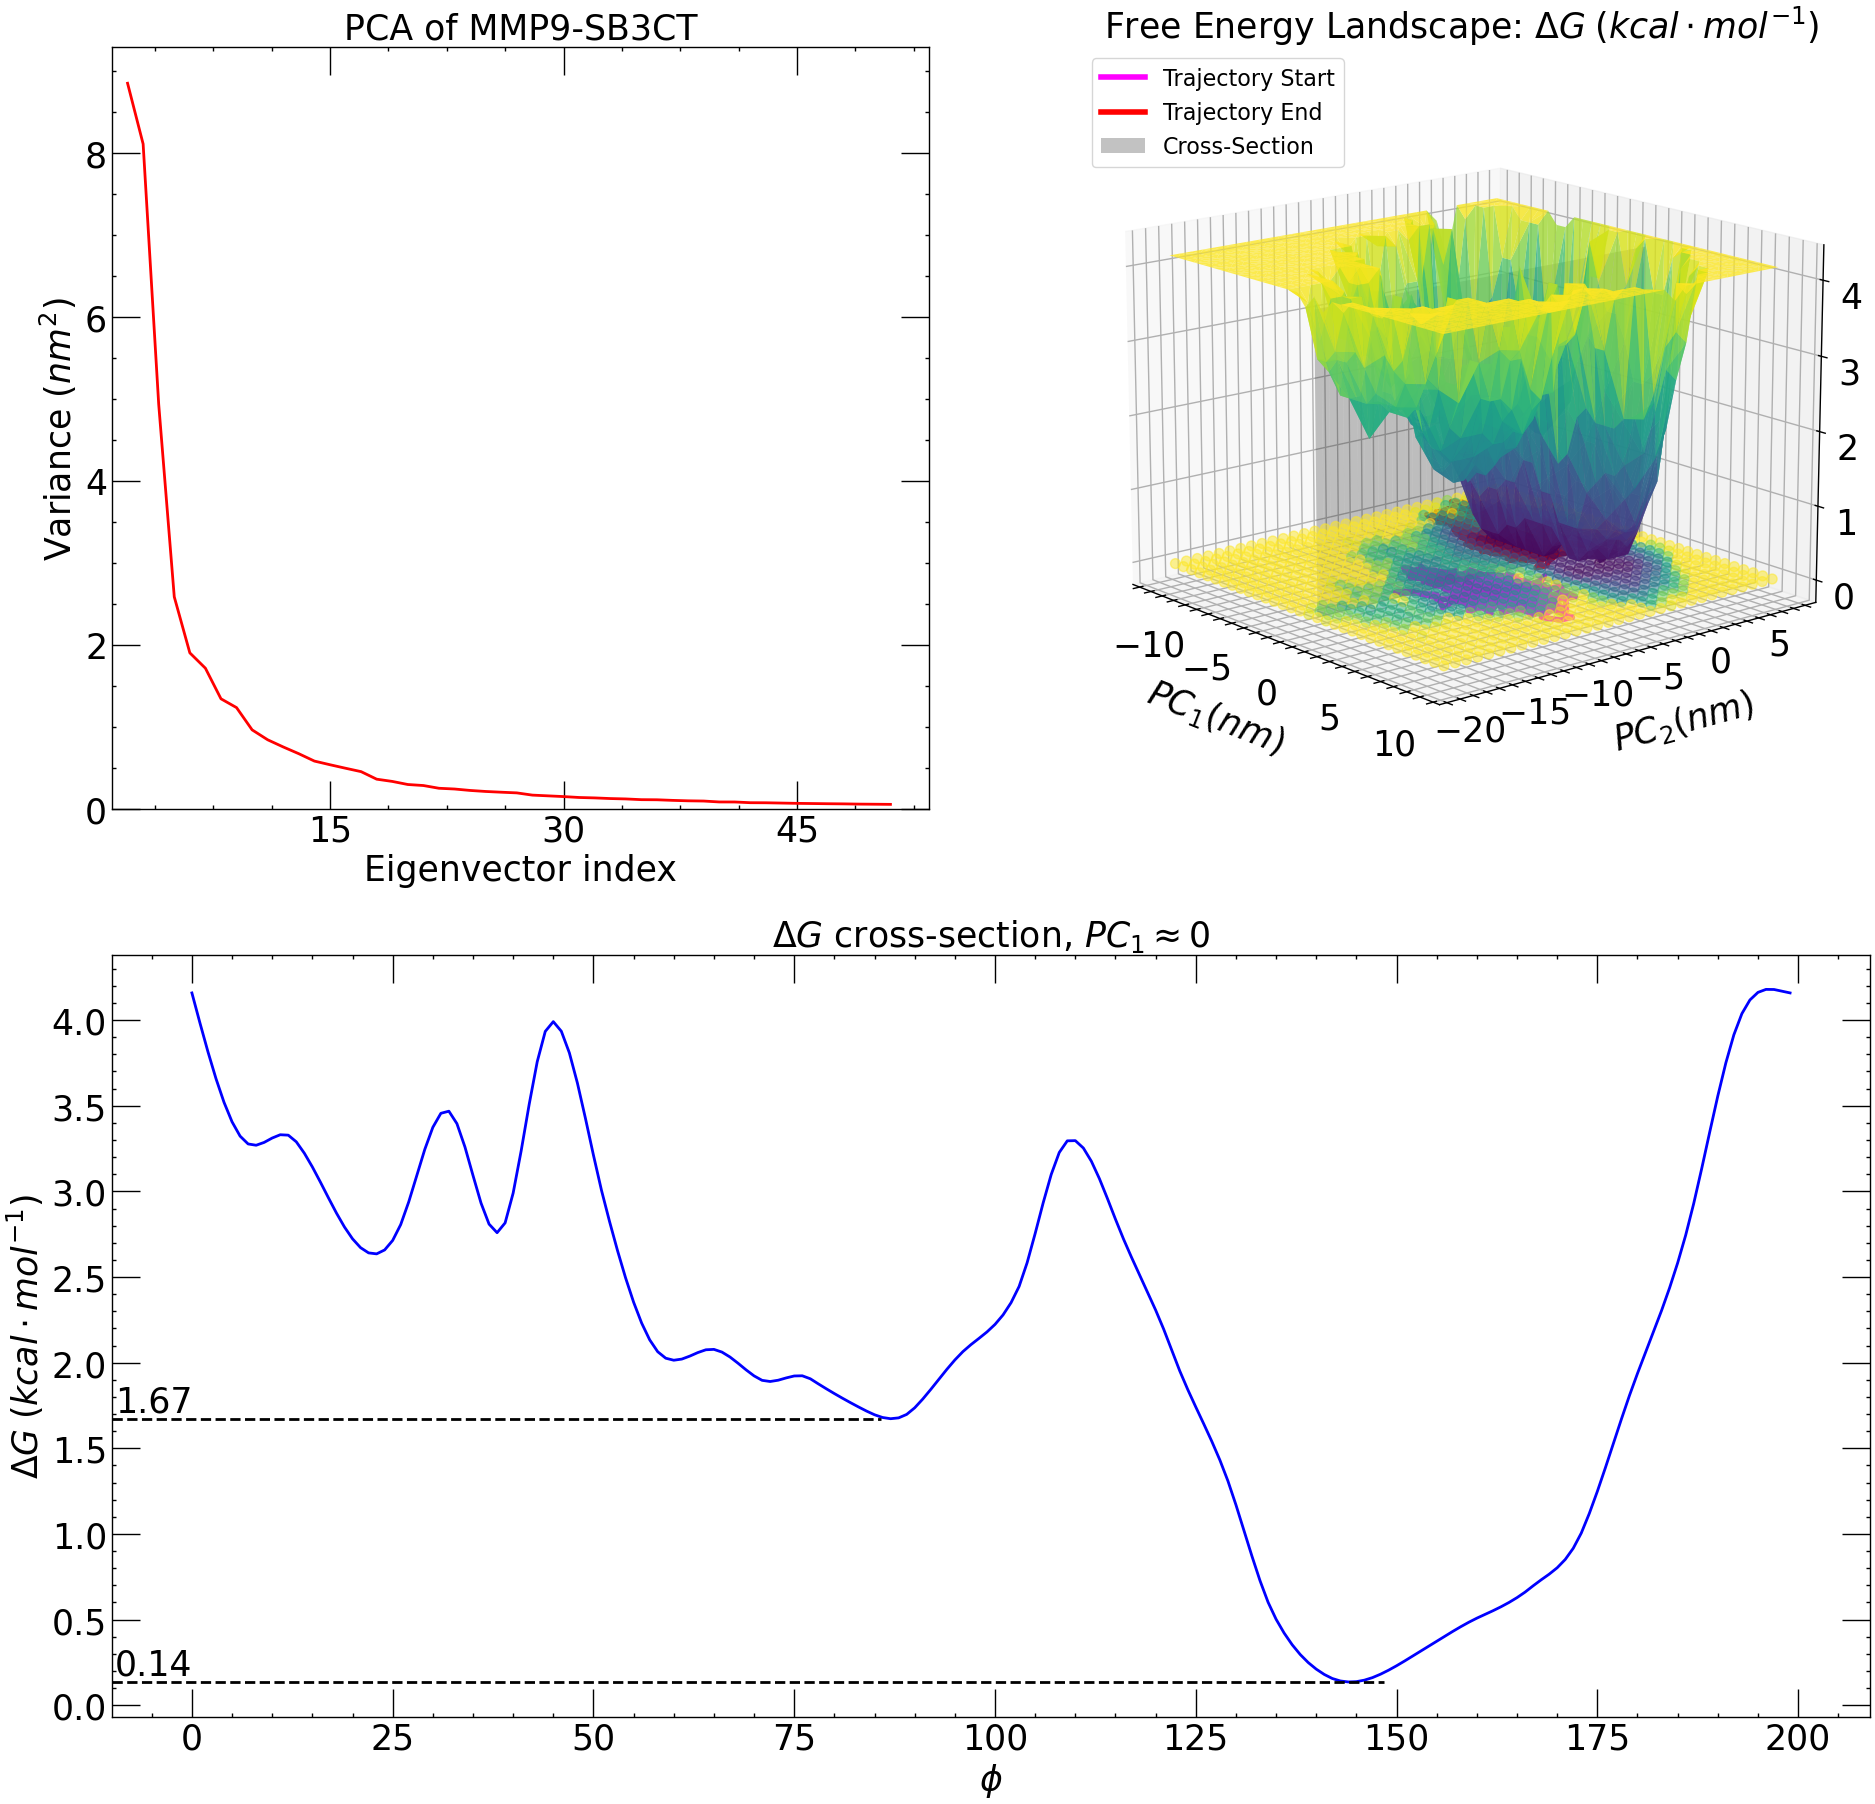

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scienceplots
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.interpolate import griddata
from scipy.signal import argrelextrema

import matplotlib.pyplot as plt

plt.style.use(['science','notebook'])

# Create a figure with 3 panels
fig = plt.figure(tight_layout=True, figsize=(35, 35))

# Upper left panel: Eigenvalue cumulative sum plot
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(time_D1[0:50], D1_data[0:50], color='red')
ax1.set_xlim(1, )
ax1.set_ylim(0, )
ax1.set_xlabel('Eigenvector index')
ax1.set_ylabel(r'Variance $\left(nm^2\right)$')
ax1.set_title('PCA of MMP9-SB3CT')
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.tick_params(axis='both', which='major')

# Upper right panel: 3D plot of the free energy
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.plot_trisurf(PC1, PC2, free_energy/4.184, cmap='viridis', alpha=0.8)
ax2.zaxis.set_rotate_label(False)  # disable automatic rotation
ax2.set_xlabel(r'$PC_1\left(nm\right)$', labelpad=25)
ax2.xaxis.set_tick_params(pad=10)
ax2.set_ylabel(r'$PC_2\left(nm\right)$', labelpad=20)
ax2.yaxis.set_tick_params(pad=0)
ax2.set_title(r'Free Energy Landscape: $\Delta G\; \left(kcal \cdot mol^{-1}\right)$')
ax2.scatter(PC1, PC2, c=free_energy/4.184, cmap='viridis', s=50, alpha=0.5)
ax2.plot(pc1_data[0:1000], pc2_data[0:1000], 0, color='magenta', linewidth=4, label='Trajectory Start')
ax2.plot(pc1_data[-2000:-1], pc2_data[-2000:-1], 0, color='red', linewidth=4, label='Trajectory End')



#Plot the cross-section
y = np.linspace(np.min(PC2), np.max(PC2), 200)
# Create a meshgrid for the plane
Y, Z = np.meshgrid(y, np.linspace(0, 4, 2))
X = 0
# Plot the plane
ax2.plot_surface(X, Y, Z, color='gray', alpha=0.3, label='Cross-Section')

ax2.view_init(elev=15, azim=-40)

# Lower panel: Cross-section plot with fitting and all points
ax3 = fig.add_subplot(2, 1, 2)
ax3.set_title(r'$\Delta G$ cross-section, $PC_1\approx 0$')

# Obtain the cross-section of the interpolant along the x-axis
x_cross_section = np.zeros_like(y)
y_plot = griddata((PC1, PC2), free_energy / 4.184,\
        (x_cross_section, y), method='cubic')

# Plot the cross-section values in ax3
x_plot = np.arange(0, len(x_cross_section))
ax3.plot(x_plot, y_plot, color='blue')
ax3.set_xlabel(r'$\phi$')
ax3.set_ylabel(r'$\Delta G\;(kcal\cdot mol^{-1})$')

# Find local minima
minima_indices = argrelextrema(y_plot, np.less)[0]
minima_x = x_plot[minima_indices]
minima_y = y_plot[minima_indices]

chosen_minima_idx = [5,6]

# Plot horizontal lines and annotate minima
for x, y in zip(minima_x[chosen_minima_idx], minima_y[chosen_minima_idx]):
    xmin = np.min(x_plot)
    xmax = np.max(x_plot)
    ax3.axhline(y=y, xmin=xmin, xmax=(x-xmin)/(xmax-xmin),\
        color='black', linestyle='dashed')
    ax3.text(np.min(x_plot)+0.1, y, f'{y:.2f}', color='black',\
        verticalalignment='bottom', horizontalalignment='right', fontsize=25)


fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax2.set_position([0.55, 0.55, 0.8, 0.8])  # [left, bottom, width, height]

# Make all mark sizes bigger
for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='both', length=20)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.xaxis.label.set_size(25)
    ax.yaxis.label.set_size(25)
    ax.title.set_size(25)
    if hasattr(ax, 'zaxis'):
        ax.zaxis.label.set_size(25)
        ax.zaxis.set_tick_params(labelsize=25)

ax2.legend(frameon=True, loc="upper left")
plt.tight_layout()
plt.savefig('free_energy_landscape.png', dpi=300)
# Show the plot
plt.show()

### PCA Conclusion

The `gromacs` way is quantitatively better, although both `gromacs` and `MDAnalysis` yield similar qualitative landscapes. I'm inclined to prefer the `gromacs` data as there are clearly fewer truncation errors in while selecting the first two principal axes compared to `MDAnalysis`.


### Some Physics

The trajectory starts from the metastable minimum (magenta), which was in the neighbourhood of the docked configuration, whose free energy was determined during the docking run. Thus, **this metastable minimum in Free Energy is that local minimum in Energy where the docking wound up**. The trajectory then goes to the global minimum at the end (red).

We plot the cross-section of $\Delta G$ at the plane of transition (visually estimated from the 3D plot) and obtain local minima by powell's dog-leg. We visually inspect and obtain the upper extremum near where the docked pose where the trajectory starts. The value of $\Delta G\approx 1.67\; kcal\cdot mol^{-1}$. The lower extremum is where the trajectory ends up, with $\Delta G \approx 0.14 \; kcal\cdot mol^{-1}$. Thus, a rough estimate of the change in free energy as the system transitions from the metastable docked pose to the final equilibrium configuration is $\Delta G \approx 0.14 - 1.67 = -1.53 \; kcal\cdot mol^{-1}$. The initial affinity at the docked pose was $=10.26 \; kcal\cdot mol^{-1}$, according to `AMDock`, so the final affinity is $\Delta G \approx -10.26-1.53 = -11.79\; kcal\cdot mol^{-1}$.

Finally, I ran the following commands to project the trajectory to the PCA components and then visualize them.


`gmx anaeig -f md500_compact_compact.xtc -s md500_start.pdb -extr md500_extreme_pc.pdb -first 1 -last 2 -n md500_pca.ndx -nframes 30 -v eigenvectors.trr`

Then load the pdbs into pymol and see that there **are no noticable** conformational changes along those PCA axes. So the shifts in $\Delta G$ are from ligand-residue behabviour.